<a href="https://colab.research.google.com/github/JiwonJJeong/midog-cnn/blob/main/experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Code adapted from Machine Learning Engineering (Cornell Tech 2025)
import torch
import numpy as np
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [2]:
from google.colab import drive
import sys
import os

# --- 1. Mount Drive ---
drive.mount('/content/drive')

# --- 2. Define Paths ---
# Path to the source code (loaders.py) - REMAINS ON DRIVE
DRIVE_CODE_PATH = '/content/drive/MyDrive/GoogleColab/dataformidogcnn/'

# Path to the zipped data file on Drive
ZIP_SOURCE_PATH = os.path.join(DRIVE_CODE_PATH, 'cropped_images.zip')

# Local disk folder where the FAST images will be unzipped
FAST_DATA_PATH = '/content/fast_data/'

# --- 3. Unzip Data (Performance Fix) ---
if not os.path.exists(FAST_DATA_PATH):
    print(f"🚀 Unzipping data from Drive to fast local disk: {FAST_DATA_PATH}")
    !mkdir -p "$FAST_DATA_PATH"
    # The -q flag silences the output. -d sets the destination directory.
    !unzip -q "$ZIP_SOURCE_PATH" -d "$FAST_DATA_PATH"

    print("✅ Data transfer complete. Starting new batch load test.")
else:
    print("Fast data directory already exists.")


# --- 4. Set Final Variables ---
# PROJECT_DIR for the rest of your notebook now points to the FAST images
PROJECT_DIR = FAST_DATA_PATH

# Add the Drive path for Python to find 'loaders.py' and other modules
if DRIVE_CODE_PATH not in sys.path:
    sys.path.append(DRIVE_CODE_PATH)
    print(f"✅ Added {DRIVE_CODE_PATH} to Python system path.")

Mounted at /content/drive
🚀 Unzipping data from Drive to fast local disk: /content/fast_data/
✅ Data transfer complete. Starting new batch load test.
✅ Added /content/drive/MyDrive/GoogleColab/dataformidogcnn/ to Python system path.


In [3]:
import pandas as pd
from loaders import create_loaders # This should now work

# Define the full path to your CSV file
CSV_PATH = os.path.join('/content/drive/MyDrive/GoogleColab/dataformidogcnn/', 'processed_annotations_with_patch_id.csv')

# Load the DataFrame and create the df_master variable
try:
    df_master = pd.read_csv(CSV_PATH)
    print(f"✅ df_master loaded successfully. Total rows: {len(df_master)}")
except FileNotFoundError:
    print(f"❌ CRITICAL ERROR: File not found at {CSV_PATH}. Execution stopping here.")
    df_master = None # Prevent NameError in next cell if failed

✅ df_master loaded successfully. Total rows: 26286


In [4]:
from loaders import create_loaders
import torchvision.transforms as transforms

TARGET_SIZE = 50
PROJECT_DIR = '/content/fast_data/'

aperio_filters = {
    'Tumor': 'human breast cancer',
    'Scanner': 'Aperio CS2',
    'Origin': 'UMC Utrecht' # Isolating patches that are ONLY from Hamamatsu XR AND Heart
}
hamamatsuS_filters = {
    'Tumor': 'human breast cancer',
    'Scanner': 'Hamamatsu S360',
    'Origin': 'UMC Utrecht'
}
hamammatsuX_filters = {
    'Tumor': 'human breast cancer',
    'Scanner': 'Hamamatsu XR',
    'Origin': 'UMC Utrecht'
}


brightness_aug_combined = transforms.ColorJitter(brightness=0.5, contrast=0.0, saturation=0.0, hue=0.0)

train_transforms_combined = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),
    brightness_aug_combined,
    transforms.ToTensor(),
])

eval_transforms_deterministic = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.ToTensor(),
])


# 2. Call the function for final deployment
# final_combined_loader = (Train + Val) using augmented transforms
# final_test_loader_det = Test using deterministic transforms
aperio_train_loader, aperio_val_loader, aperio_test_loader = create_loaders(
    df_master, # Your master DataFrame
    patch_dir=PROJECT_DIR,
    filters=aperio_filters,
    train_transform=train_transforms_combined,      # Applied to Train + Val
    eval_transform=eval_transforms_deterministic,    # Applied to Test
    final_train=False # Activates combination mode
)


--- Data Split Summary ---
Original Total Annotations: 1612
Train Annotations: 1128 (70.0%)
Validation Annotations: 242 (15.0%)
Test Annotations: 242 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32


In [5]:
hamaS_train_loader, hamaS_val_loader, hamaS_test_loader = create_loaders(
    df_master, # Your master DataFrame
    patch_dir=PROJECT_DIR,
    filters=hamamatsuS_filters,
    train_transform=train_transforms_combined,      # Applied to Train + Val
    eval_transform=eval_transforms_deterministic,    # Applied to Test
    final_train=False # Activates combination mode
)


--- Data Split Summary ---
Original Total Annotations: 1648
Train Annotations: 1152 (69.9%)
Validation Annotations: 248 (15.0%)
Test Annotations: 248 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32


In [6]:
hamaX_train_loader, hamaX_val_loader, hamaX_test_loader = create_loaders(
    df_master, # Your master DataFrame
    patch_dir=PROJECT_DIR,
    filters=hamammatsuX_filters,
    train_transform=train_transforms_combined,      # Applied to Train + Val
    eval_transform=eval_transforms_deterministic,    # Applied to Test
    final_train=False # Activates combination mode
)


--- Data Split Summary ---
Original Total Annotations: 1175
Train Annotations: 821 (69.9%)
Validation Annotations: 177 (15.1%)
Test Annotations: 177 (15.1%)

DataLoaders created successfully.
Train Loader batch size: 32


In [7]:
from loaders import evaluate, train_CNN

In [8]:
def init_weights(module):
    """Initialize weights for CNNs using He (Kaiming) for ReLU."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        # Use He/Kaiming Uniform initialization
        nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')

        if module.bias is not None:
            # Initialize biases to zero
            nn.init.constant_(module.bias, 0)

In [9]:
import torch.nn as nn

class lenet5_relu_max_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(84),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [10]:
single_domain_accuracies = {}

Epoch 0 (Initial): Train Acc = 0.5727, Test Acc = 0.5744
Epoch 10: Train Acc = 0.5727, Test Acc = 0.5744
Epoch 20: Train Acc = 0.6356, Test Acc = 0.6116
Epoch 30: Train Acc = 0.6640, Test Acc = 0.6529
Epoch 40: Train Acc = 0.6888, Test Acc = 0.6570
Epoch 50: Train Acc = 0.7110, Test Acc = 0.6653


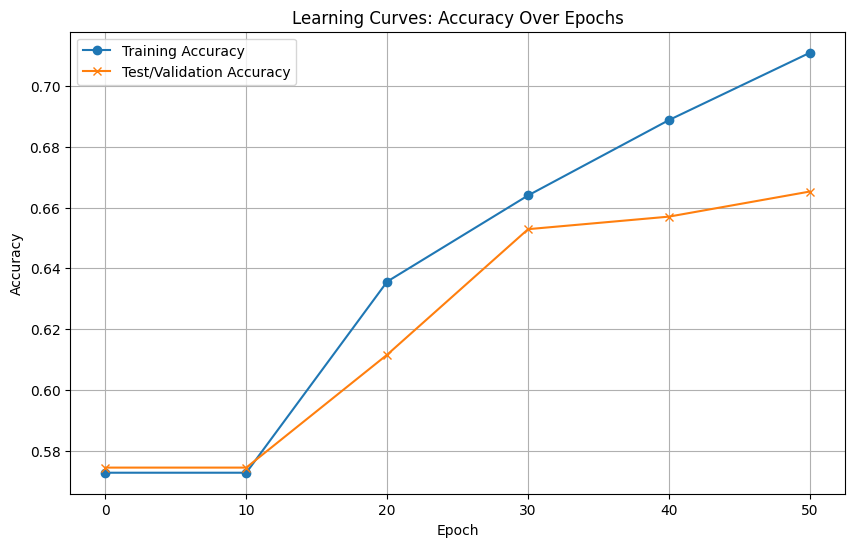


Training Complete. Final Train Acc: 0.7110, Final Test Acc: 0.6653


In [11]:
model = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model, aperio_train_loader, aperio_val_loader, num_epochs=50)
single_domain_accuracies["Aperio CS2"] = (trainacc, valacc)

Epoch 0 (Initial): Train Acc = 0.3542, Test Acc = 0.3548
Epoch 10: Train Acc = 0.6476, Test Acc = 0.6452
Epoch 20: Train Acc = 0.6953, Test Acc = 0.6653
Epoch 30: Train Acc = 0.7170, Test Acc = 0.6694
Epoch 40: Train Acc = 0.7057, Test Acc = 0.6895
Epoch 50: Train Acc = 0.7439, Test Acc = 0.6573


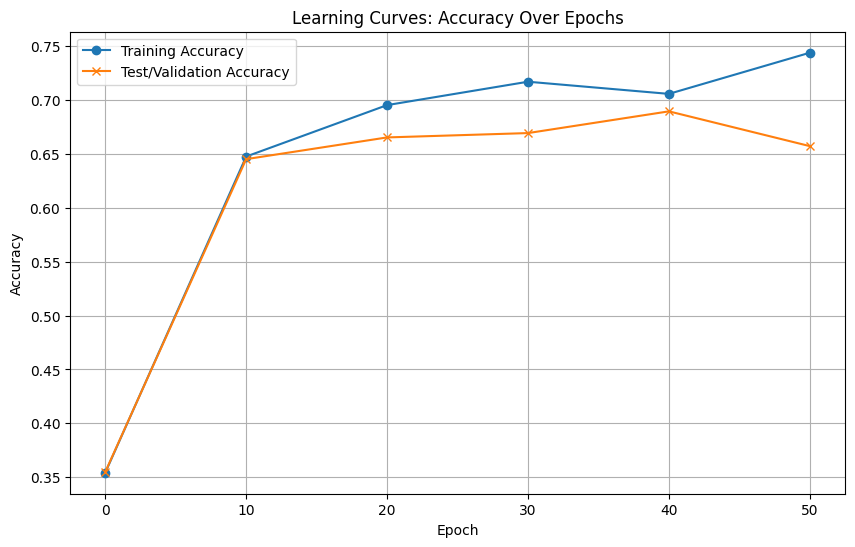


Training Complete. Final Train Acc: 0.7439, Final Test Acc: 0.6573


In [12]:
model2 = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model2, hamaS_train_loader, hamaS_val_loader, num_epochs=50)
single_domain_accuracies["Hamamatsu S360"] = (trainacc, valacc)

Epoch 0 (Initial): Train Acc = 0.3837, Test Acc = 0.3842
Epoch 10: Train Acc = 0.6163, Test Acc = 0.6158
Epoch 20: Train Acc = 0.6468, Test Acc = 0.6215
Epoch 30: Train Acc = 0.6407, Test Acc = 0.6271
Epoch 40: Train Acc = 0.7028, Test Acc = 0.6441
Epoch 50: Train Acc = 0.6590, Test Acc = 0.6215


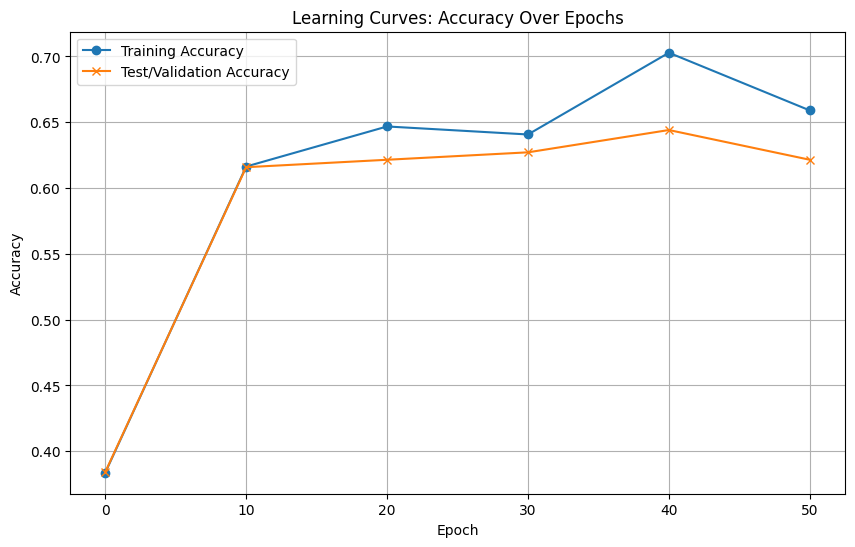


Training Complete. Final Train Acc: 0.6590, Final Test Acc: 0.6215


In [13]:
model3 = lenet5_relu_max_dropout()
trainacc, valacc = train_CNN(model3, hamaX_train_loader, hamaX_val_loader, num_epochs=50)
single_domain_accuracies["Hamamatsu XR"] = (trainacc, valacc)

In [14]:
single_domain_accuracies

{'Aperio CS2': (0.7109929078014184, 0.6652892561983471),
 'Hamamatsu S360': (0.7439236111111112, 0.657258064516129),
 'Hamamatsu XR': (0.658952496954933, 0.6214689265536724)}

scanner_comparison_metrics.png


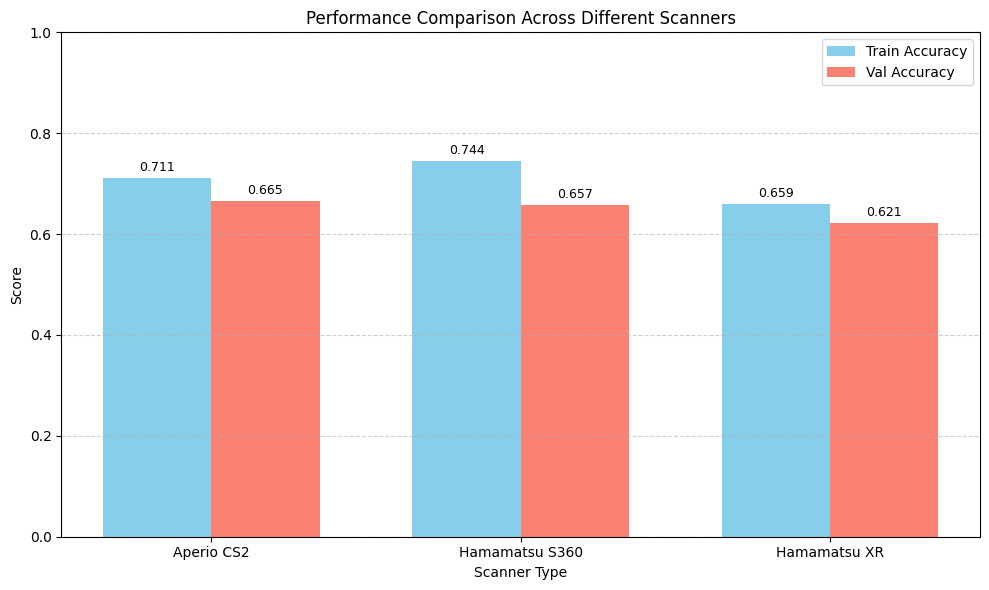

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data provided by the user
data = single_domain_accuracies

# Convert dictionary to DataFrame
df = pd.DataFrame.from_dict(data, orient='index', columns=['Metric A', 'Metric B'])
df.index.name = 'Scanner'
df = df.reset_index()

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define bar width and positions
bar_width = 0.35
x = np.arange(len(df['Scanner']))

# Plot Metric A
rects1 = ax.bar(x - bar_width/2, df['Metric A'], bar_width, label='Train Accuracy', color='skyblue')

# Plot Metric B
rects2 = ax.bar(x + bar_width/2, df['Metric B'], bar_width, label='Val Accuracy', color='salmon')

# Helper function to attach a label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

autolabel(rects1)
autolabel(rects2)

# Set labels, title, and ticks
ax.set_ylabel('Score')
ax.set_xlabel('Scanner Type')
ax.set_title('Performance Comparison Across Different Scanners')
ax.set_xticks(x)
ax.set_xticklabels(df['Scanner'], rotation=0)
ax.legend()

# Set y-axis limits and grid
ax.set_ylim(0.0, 1.0)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Tight layout to prevent labels from cutting off
plt.tight_layout()

# Save the plot
plt.savefig('scanner_comparison_metrics.png')

print('scanner_comparison_metrics.png')

In [16]:
import torch
import pandas as pd
from typing import List, Dict, Tuple, Callable
import torch.nn as nn
from torch.utils.data import DataLoader

# =========================================================================
# NOTE: The custom evaluate function must be defined/imported in your environment.
# Signature assumed: (model, train_loader, val_loader, device) -> (train_acc, val_acc)
# =========================================================================

def generate_cross_domain_matrix(
    models: List[nn.Module],
    model_names: List[str],
    aperio_loaders: List[DataLoader],
    hamaS_loaders: List[DataLoader],
    hamaX_loaders: List[DataLoader],
    evaluate_func: Callable, # Your custom evaluate function
    splits_to_evaluate: List[str] = None,
    device: torch.device = None
) -> pd.DataFrame:
    """
    Calculates the cross-domain accuracy matrix by evaluating each model
    on specified validation splits for each scanner type.

    Args:
        models (List[nn.Module]): List of trained models.
        model_names (List[str]): Names corresponding to the models.
        aperio_loaders (List[DataLoader]): [train, val, test] loaders for Aperio.
        hamaS_loaders (List[DataLoader]): [train, val, test] loaders for Hamamatsu S.
        hamaX_loaders (List[DataLoader]): [train, val, test] loaders for Hamamatsu X.
        evaluate_func (Callable): Your custom function with signature: (model, train_loader, val_loader, device) -> (train_acc, val_acc).
        splits_to_evaluate (List[str], optional): Which splits to run ('Val', 'Test', etc.). Defaults to ['Val'].
        device (torch.device, optional): Device to run evaluation on. Defaults to 'cuda' if available.

    Returns:
        pd.DataFrame: A matrix with models in rows and domains in columns.
    """
    if splits_to_evaluate is None:
        splits_to_evaluate = ['Val']

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Map split names to list indices (assuming [train, val, test])
    split_map = {'Train': 0, 'Val': 1, 'Test': 2}

    # 1. ORGANIZE LOADERS
    all_scanners = {
        'Aperio': {k: aperio_loaders[split_map[k]] for k in split_map},
        'HamaS':  {k: hamaS_loaders[split_map[k]] for k in split_map},
        'HamaX':  {k: hamaX_loaders[split_map[k]] for k in split_map},
    }

    accs = {}

    # Set all models to evaluation mode and move to device
    print(f"Starting Cross-Domain Evaluation on {device}...")
    for m in models:
        m.to(device).eval()

    # 2. THE ITERATION LOOP
    for model_name, current_model in zip(model_names, models):
        print(f"\nEvaluating Model: {model_name}")
        for target_scanner_name, splits in all_scanners.items():

            # Use Train split of the current scanner as the first argument (to satisfy API)
            assumed_train_loader = splits['Train']

            for split_type in splits_to_evaluate:
                target_loader = splits[split_type]
                domain_name = f"{target_scanner_name}_{split_type}"

                if target_loader is None or assumed_train_loader is None:
                    accs[(model_name, domain_name)] = float('nan')
                    continue

                # Calling the custom evaluate function
                # Unpack the tuple: (_, accuracy)
                try:
                    _, accuracy = evaluate_func(
                        current_model,
                        assumed_train_loader,
                        target_loader,
                        device
                    )
                except Exception as e:
                    print(f"Error evaluating {model_name} on {domain_name}: {e}")
                    accuracy = float('nan') # Record NaN on failure

                accs[(model_name, domain_name)] = accuracy
                print(f"  -> {domain_name}: {accuracy:.4f}")

    # 3. CONVERSION TO DATAFRAME
    results_series = pd.Series(accs)
    cross_domain_df = results_series.unstack(level=1)

    return cross_domain_df


aperio_loaders = [aperio_train_loader, aperio_val_loader, aperio_test_loader]
hamaS_loaders = [hamaS_train_loader, hamaS_val_loader, hamaS_test_loader]
hamaX_loaders = [hamaX_train_loader, hamaX_val_loader, hamaX_test_loader]


# # Example Call (Uncomment and replace placeholders with your actual objects):
final_df = generate_cross_domain_matrix(
     models=[model, model2, model3],
     model_names=["Aperio T", "Hama S T", "Hama X T"],
     aperio_loaders=aperio_loaders,
     hamaS_loaders=hamaS_loaders,
     hamaX_loaders=hamaX_loaders,
     evaluate_func=evaluate, # Your actual evaluation function
     splits_to_evaluate=['Val'] # Evaluates Validation splits only
)

print("\nFinal Cross-Domain Matrix:")
print(final_df.round(4))

Starting Cross-Domain Evaluation on cuda...

Evaluating Model: Aperio T
  -> Aperio_Val: 0.6653
  -> HamaS_Val: 0.6734
  -> HamaX_Val: 0.4124

Evaluating Model: Hama S T
  -> Aperio_Val: 0.6529
  -> HamaS_Val: 0.6573
  -> HamaX_Val: 0.4972

Evaluating Model: Hama X T
  -> Aperio_Val: 0.5744
  -> HamaS_Val: 0.6452
  -> HamaX_Val: 0.6215

Final Cross-Domain Matrix:
          Aperio_Val  HamaS_Val  HamaX_Val
Aperio T      0.6653     0.6734     0.4124
Hama S T      0.6529     0.6573     0.4972
Hama X T      0.5744     0.6452     0.6215


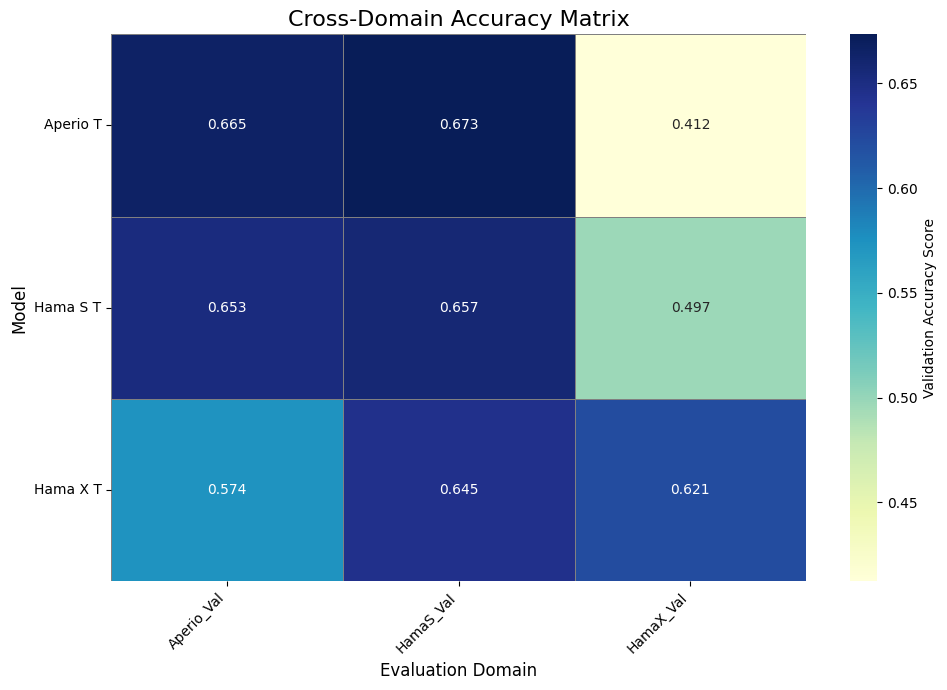

In [19]:
plot_cross_domain_heatmap(final_df)

In [20]:
import torch.nn as nn

class lenet5_relu_max_dropout_bn(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.BatchNorm1d(120),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(84),
            nn.BatchNorm1d(84),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(2),
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

In [21]:
single_domain_accuracies_bn = {}

Epoch 0 (Initial): Train Acc = 0.5727, Test Acc = 0.5744
Epoch 10: Train Acc = 0.6348, Test Acc = 0.5868
Epoch 20: Train Acc = 0.6879, Test Acc = 0.6612
Epoch 30: Train Acc = 0.7624, Test Acc = 0.6488
Epoch 40: Train Acc = 0.7482, Test Acc = 0.6157
Epoch 50: Train Acc = 0.7677, Test Acc = 0.6777


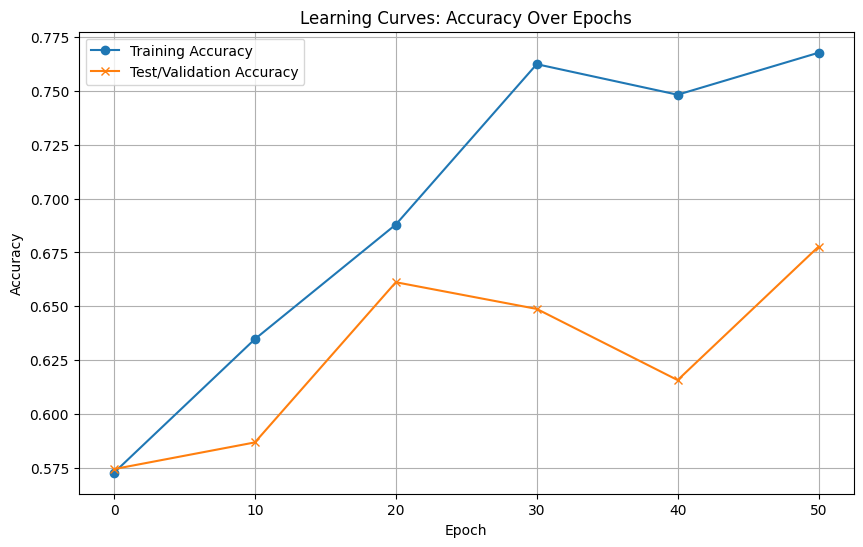


Training Complete. Final Train Acc: 0.7677, Final Test Acc: 0.6777


In [22]:
model = lenet5_relu_max_dropout_bn()
trainacc, valacc = train_CNN(model, aperio_train_loader, aperio_val_loader, num_epochs=50)
single_domain_accuracies_bn["Aperio CS2"] = (trainacc, valacc)

Epoch 0 (Initial): Train Acc = 0.6476, Test Acc = 0.6452
Epoch 10: Train Acc = 0.6675, Test Acc = 0.6452
Epoch 20: Train Acc = 0.6701, Test Acc = 0.6492
Epoch 30: Train Acc = 0.7743, Test Acc = 0.7540
Epoch 40: Train Acc = 0.7431, Test Acc = 0.7097
Epoch 50: Train Acc = 0.7865, Test Acc = 0.6855


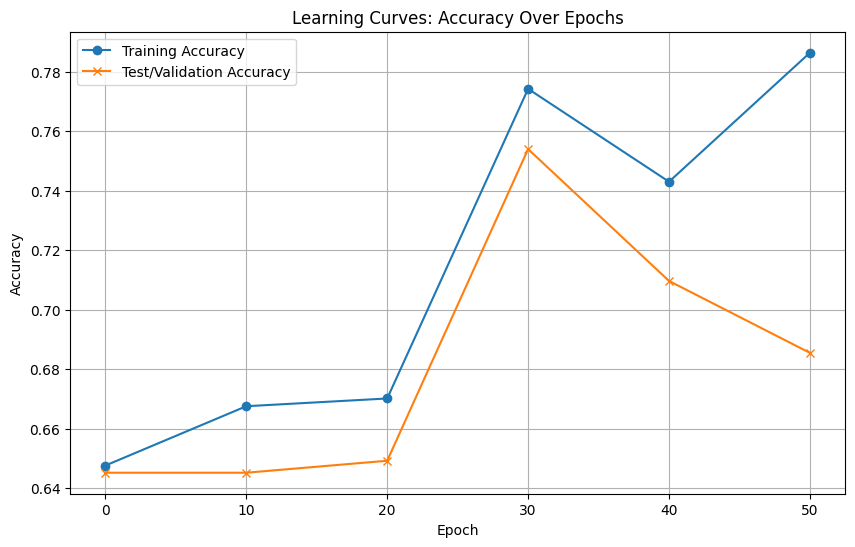


Training Complete. Final Train Acc: 0.7865, Final Test Acc: 0.6855


In [23]:
model2 = lenet5_relu_max_dropout_bn()
trainacc, valacc = train_CNN(model2, hamaS_train_loader, hamaS_val_loader, num_epochs=50)
single_domain_accuracies_bn["Hamamatsu S360"] = (trainacc, valacc)

Epoch 0 (Initial): Train Acc = 0.3837, Test Acc = 0.3842
Epoch 10: Train Acc = 0.6833, Test Acc = 0.6610
Epoch 20: Train Acc = 0.7186, Test Acc = 0.6836
Epoch 30: Train Acc = 0.6602, Test Acc = 0.6441
Epoch 40: Train Acc = 0.7978, Test Acc = 0.7232
Epoch 50: Train Acc = 0.8124, Test Acc = 0.6836


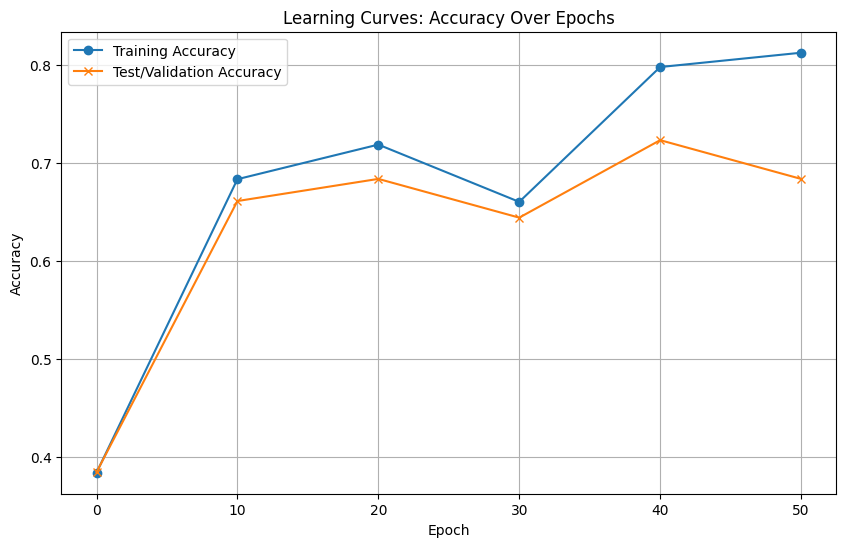


Training Complete. Final Train Acc: 0.8124, Final Test Acc: 0.6836


In [24]:
model3 = lenet5_relu_max_dropout_bn()
trainacc, valacc = train_CNN(model3, hamaX_train_loader, hamaX_val_loader, num_epochs=50)
single_domain_accuracies_bn["Hamamatsu XR"] = (trainacc, valacc)

In [25]:
final_df = generate_cross_domain_matrix(
     models=[model, model2, model3],
     model_names=["Aperio", "Hama S360", "Hama XR"],
     aperio_loaders=aperio_loaders,
     hamaS_loaders=hamaS_loaders,
     hamaX_loaders=hamaX_loaders,
     evaluate_func=evaluate, # Your actual evaluation function
     splits_to_evaluate=['Val'] # Evaluates Validation splits only
)

Starting Cross-Domain Evaluation on cuda...

Evaluating Model: Aperio
  -> Aperio_Val: 0.6777
  -> HamaS_Val: 0.6935
  -> HamaX_Val: 0.4746

Evaluating Model: Hama S360
  -> Aperio_Val: 0.6529
  -> HamaS_Val: 0.6855
  -> HamaX_Val: 0.5311

Evaluating Model: Hama XR
  -> Aperio_Val: 0.5785
  -> HamaS_Val: 0.6492
  -> HamaX_Val: 0.6836


In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional

def plot_cross_domain_heatmap(
    cross_domain_df: pd.DataFrame,
    title: str = "Cross-Domain Accuracy Matrix",
    cmap: str = "YlGnBu",
    output_filename: Optional[str] = None
) -> None:
    """
    Generates a seaborn heatmap visualization of the cross-domain accuracy matrix.

    Args:
        cross_domain_df (pd.DataFrame): The DataFrame where rows are models and
                                        columns are evaluation domains (e.g., Aperio_Val).
        title (str): The title for the plot.
        cmap (str): The matplotlib color map to use (e.g., 'YlGnBu', 'viridis', 'coolwarm').
        output_filename (str, optional): If provided, saves the plot to this file path.
    """

    # Set the size of the figure
    plt.figure(figsize=(10, 7))

    # Create the heatmap
    sns.heatmap(
        cross_domain_df.astype(float), # Ensure data is float for color mapping
        annot=True,                    # Show the accuracy values on the map
        fmt=".3f",                     # Format annotations to 3 decimal places
        cmap=cmap,                     # Color map
        linewidths=0.5,                # Lines between cells
        linecolor='gray',
        cbar_kws={'label': 'Validation Accuracy Score'} # Color bar label
    )

    # Set labels and title
    plt.title(title, fontsize=16)
    plt.xlabel('Evaluation Domain', fontsize=12)
    plt.ylabel('Model', fontsize=12)

    # Rotate axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Adjust layout to prevent labels from being cut off
    plt.tight_layout()

    # Save or show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight')
        print(f"Heatmap saved to {output_filename}")
    else:
        plt.show()

#

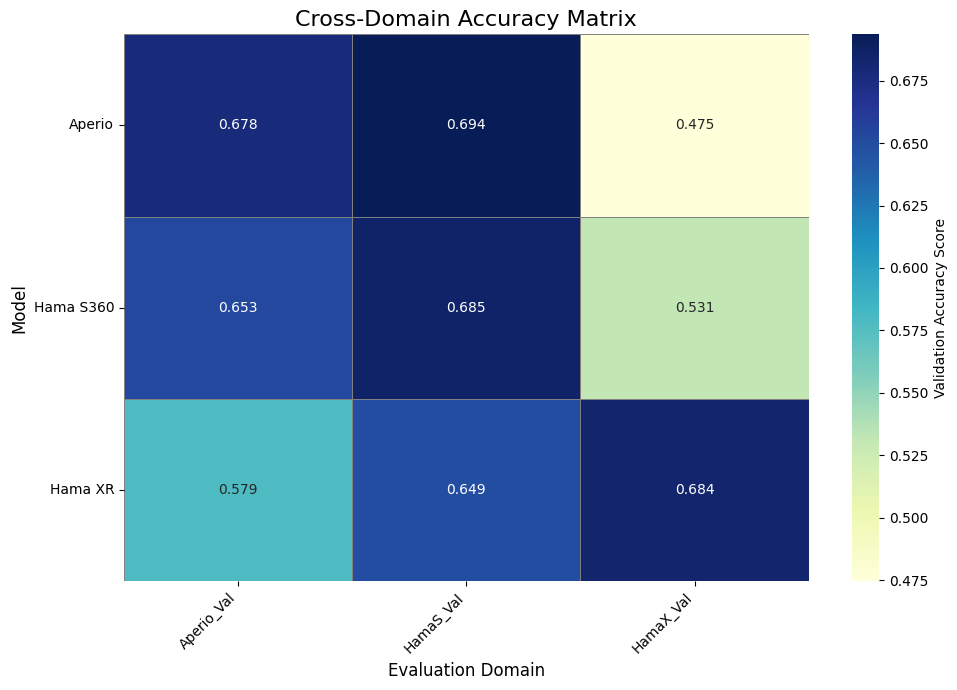

In [27]:
plot_cross_domain_heatmap(final_df)

In [29]:
from torch.utils.data import ConcatDataset, DataLoader

# 2. Access the datasets from individual training loaders
aperio_train_dataset = aperio_train_loader.dataset
hamaS_train_dataset = hamaS_train_loader.dataset
hamaX_train_dataset = hamaX_train_loader.dataset

# 3. Create a combined_train_dataset
combined_train_dataset = ConcatDataset([
    aperio_train_dataset,
    hamaS_train_dataset,
    hamaX_train_dataset
])

# 4. Create combined_train_loader
combined_train_loader = DataLoader(
    combined_train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
)

print(f"Combined train dataset size: {len(combined_train_dataset)}")
print(f"Combined train loader batch size: {combined_train_loader.batch_size}")

# 5. Access the datasets from individual validation loaders
aperio_val_dataset = aperio_val_loader.dataset
hamaS_val_dataset = hamaS_val_loader.dataset
hamaX_val_dataset = hamaX_val_loader.dataset

# 6. Create a combined_val_dataset
combined_val_dataset = ConcatDataset([
    aperio_val_dataset,
    hamaS_val_dataset,
    hamaX_val_dataset
])

# 7. Create combined_val_loader
combined_val_loader = DataLoader(
    combined_val_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False
)

print(f"Combined validation dataset size: {len(combined_val_dataset)}")
print(f"Combined validation loader batch size: {combined_val_loader.batch_size}")

Combined train dataset size: 3101
Combined train loader batch size: 32
Combined validation dataset size: 667
Combined validation loader batch size: 32


Epoch 0 (Initial): Train Acc = 0.3890, Test Acc = 0.3883
Epoch 10: Train Acc = 0.6553, Test Acc = 0.6477
Epoch 20: Train Acc = 0.7194, Test Acc = 0.6762
Epoch 30: Train Acc = 0.7331, Test Acc = 0.6972


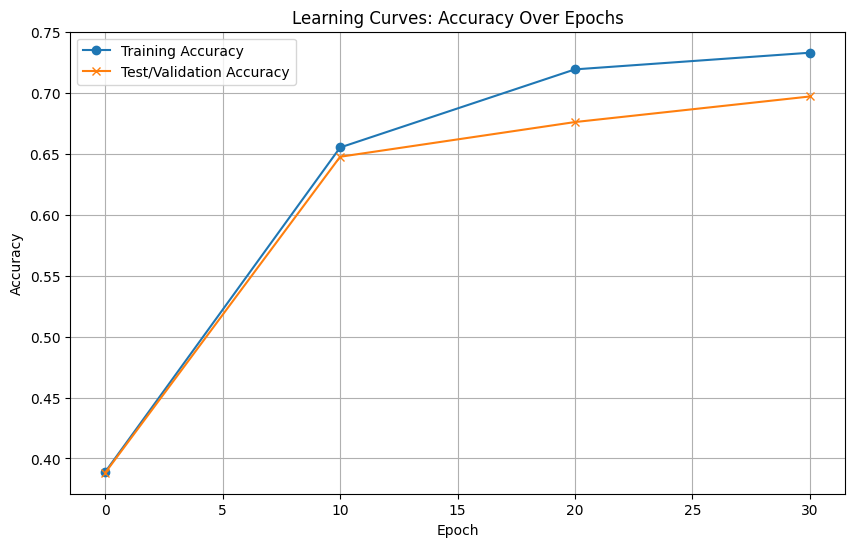


Training Complete. Final Train Acc: 0.7331, Final Test Acc: 0.6972
Combined Model - Final Train Acc: 0.7331, Final Val Acc: 0.6972


In [33]:
combined_model = lenet5_relu_max_dropout_bn()
combined_train_acc, combined_val_acc = train_CNN(combined_model, combined_train_loader, combined_val_loader, num_epochs=30)
print(f"Combined Model - Final Train Acc: {combined_train_acc:.4f}, Final Val Acc: {combined_val_acc:.4f}")

## Evaluate Combined Model on Individual Validation Sets

### Subtask:
Evaluate the newly trained combined model's performance on the individual validation sets of Aperio, Hamamatsu S360, and Hamamatsu XR scanners, and add its performance to the existing `final_df`.


**Reasoning**:
Evaluate the newly trained combined model's performance on individual validation sets using the `generate_cross_domain_matrix` function, as specified in the instructions.



In [34]:
combined_model_df = generate_cross_domain_matrix(
    models=[combined_model],
    model_names=["Combined"],
    aperio_loaders=aperio_loaders,
    hamaS_loaders=hamaS_loaders,
    hamaX_loaders=hamaX_loaders,
    evaluate_func=evaluate,
    splits_to_evaluate=['Val']
)

final_df = pd.concat([final_df, combined_model_df], axis=0)

print("\nUpdated Cross-Domain Matrix with Combined Model:")
print(final_df.round(4))

Starting Cross-Domain Evaluation on cuda...

Evaluating Model: Combined
  -> Aperio_Val: 0.6860
  -> HamaS_Val: 0.6935
  -> HamaX_Val: 0.7175

Updated Cross-Domain Matrix with Combined Model:
           Aperio_Val  HamaS_Val  HamaX_Val
Aperio         0.6777     0.6935     0.4746
Hama S360      0.6529     0.6855     0.5311
Hama XR        0.5785     0.6492     0.6836
Combined       0.5165     0.5565     0.4859
Combined       0.6860     0.6935     0.7175


In [36]:
final_df

,Aperio_Val,HamaS_Val,HamaX_Val
Aperio,0.677686,0.693548,0.474576
Hama S360,0.652893,0.685484,0.531073
Hama XR,0.578512,0.649194,0.683616
Combined,0.516529,0.556452,0.485876
Combined,0.685950,0.693548,0.717514


In [37]:
new_index = final_df.index.tolist()

combined_rows = [i for i, name in enumerate(new_index) if name == 'Combined']

if len(combined_rows) >= 2:
    new_index[combined_rows[1]] = 'Combined (Early Stopping)'
    final_df.index = new_index
else:
    print("Warning: Could not find a second 'Combined' row to rename.")

display(final_df.round(4))

,Aperio_Val,HamaS_Val,HamaX_Val
Aperio,0.6777,0.6935,0.4746
Hama S360,0.6529,0.6855,0.5311
Hama XR,0.5785,0.6492,0.6836
Combined,0.5165,0.5565,0.4859
Combined (Early Stopping),0.6860,0.6935,0.7175


## Visualize Updated Cross-Domain Heatmap

### Subtask:
Generate a new heatmap using `plot_cross_domain_heatmap` to visualize the updated `final_df`, now including the performance of the model trained on all combined domains.


**Reasoning**:
I need to call the `plot_cross_domain_heatmap` function with the updated `final_df` to visualize the cross-domain accuracy, including the combined model's performance, and save the output to a file.



Heatmap saved to cross_domain_heatmap_combined.png


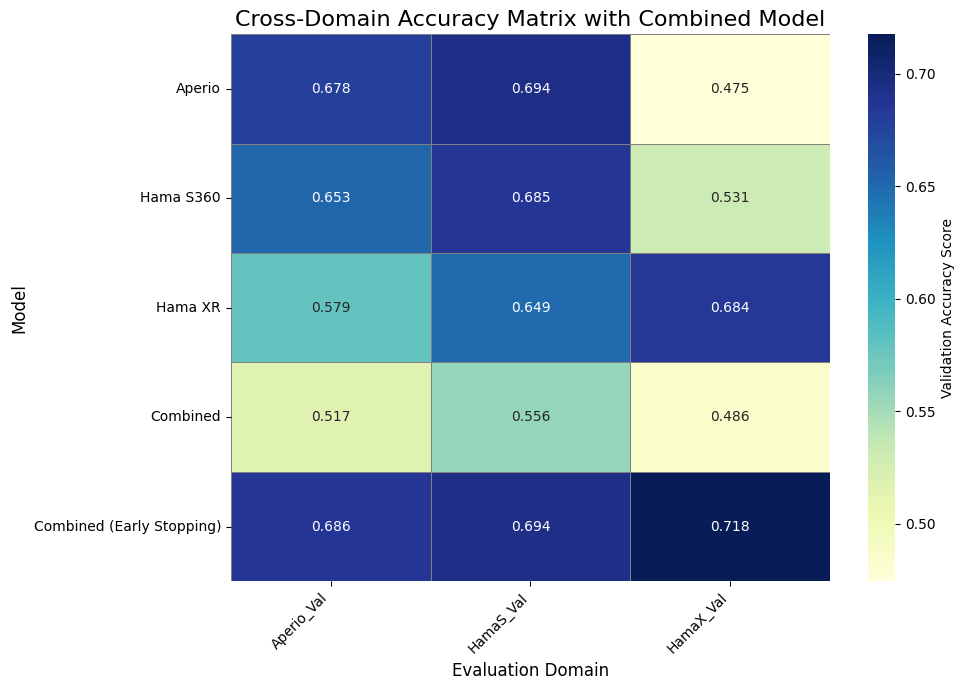

In [38]:
plot_cross_domain_heatmap(
    final_df,
    title="Cross-Domain Accuracy Matrix with Combined Model",
    output_filename="cross_domain_heatmap_combined.png"
)

In [49]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# 2. Define a custom SourceLabeledDataset class
class SourceLabeledDataset(Dataset):
    def __init__(self, base_dataset, source_label):
        self.base_dataset = base_dataset
        self.source_label = source_label

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        original_image, original_label = self.base_dataset[idx]
        return original_image, (original_label, self.source_label)

# 3. Create three instances of SourceLabeledDataset for training data
aperio_train_labeled = SourceLabeledDataset(aperio_train_loader.dataset, 0) # 0 for Aperio
hamaS_train_labeled = SourceLabeledDataset(hamaS_train_loader.dataset, 1)   # 1 for Hamamatsu S360
hamaX_train_labeled = SourceLabeledDataset(hamaX_train_loader.dataset, 2)   # 2 for Hamamatsu XR

# 4. Concatenate these three labeled training datasets
combined_source_train_dataset = ConcatDataset([
    aperio_train_labeled,
    hamaS_train_labeled,
    hamaX_train_labeled
])

# 5. Create a DataLoader named source_train_loader
source_train_loader = DataLoader(
    combined_source_train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
)

# 6. Create three instances of SourceLabeledDataset for validation data
aperio_val_labeled = SourceLabeledDataset(aperio_val_loader.dataset, 0)
hamaS_val_labeled = SourceLabeledDataset(hamaS_val_loader.dataset, 1)
hamaX_val_labeled = SourceLabeledDataset(hamaX_val_loader.dataset, 2)

# 7. Concatenate these three labeled validation datasets
combined_source_val_dataset = ConcatDataset([
    aperio_val_labeled,
    hamaS_val_labeled,
    hamaX_val_labeled
])

# 8. Create a DataLoader named source_val_loader
source_val_loader = DataLoader(
    combined_source_val_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False
)

# 9. Print the total number of images in combined_source_train_dataset and combined_source_val_dataset
print(f"Combined Source Train Dataset size: {len(combined_source_train_dataset)}")
print(f"Combined Source Validation Dataset size: {len(combined_source_val_dataset)}")

Combined Source Train Dataset size: 3101
Combined Source Validation Dataset size: 667


In [50]:
import torch.nn as nn

class SourceClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.BatchNorm1d(120),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(84),
            nn.BatchNorm1d(84),
            nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(3), # Output 3 classes for source classification
        )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

print("SourceClassifier model defined with 3 output classes.")

SourceClassifier model defined with 3 output classes.


In [60]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Define the robust SourceLabeledDataset class
class SourceLabeledDataset(Dataset):
    def __init__(self, base_dataset, source_label):
        self.base_dataset = base_dataset
        self.source_label = source_label

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        item_from_base = self.base_dataset[idx]
        original_image = None

        # Robust extraction logic
        if isinstance(item_from_base, dict):
            # Avoid boolean ambiguity by checking keys or checking for None explicitly
            original_image = item_from_base.get('image')
            if original_image is None:
                original_image = item_from_base.get('images')

            if original_image is None:
                # Fallback: check values for a tensor
                for k, v in item_from_base.items():
                    if isinstance(v, torch.Tensor) and v.ndim == 3: # C, H, W assumption
                         original_image = v
                         break
        elif isinstance(item_from_base, (tuple, list)):
            # Assume image is at index 0
            if len(item_from_base) > 0:
                original_image = item_from_base[0]
        elif isinstance(item_from_base, torch.Tensor):
            original_image = item_from_base

        if original_image is None:
             raise ValueError(f"Could not extract image from item at index {idx}. Type: {type(item_from_base)}")

        # Return simple tuple: (image, source_label)
        return original_image, self.source_label

# 2. Re-create Loaders with the new dataset class
# Create labeled datasets
aperio_train_labeled = SourceLabeledDataset(aperio_train_loader.dataset, 0)
hamaS_train_labeled = SourceLabeledDataset(hamaS_train_loader.dataset, 1)
hamaX_train_labeled = SourceLabeledDataset(hamaX_train_loader.dataset, 2)

# Concatenate for training
combined_source_train_dataset = ConcatDataset([aperio_train_labeled, hamaS_train_labeled, hamaX_train_labeled])
source_train_loader = DataLoader(combined_source_train_dataset, batch_size=32, shuffle=True, drop_last=True)

# Create labeled validation datasets
aperio_val_labeled = SourceLabeledDataset(aperio_val_loader.dataset, 0)
hamaS_val_labeled = SourceLabeledDataset(hamaS_val_loader.dataset, 1)
hamaX_val_labeled = SourceLabeledDataset(hamaX_val_loader.dataset, 2)

# Concatenate for validation
combined_source_val_dataset = ConcatDataset([aperio_val_labeled, hamaS_val_labeled, hamaX_val_labeled])
source_val_loader = DataLoader(combined_source_val_dataset, batch_size=32, shuffle=False, drop_last=False)

print(f"Source Train Loader Batches: {len(source_train_loader)}")
print(f"Source Val Loader Batches: {len(source_val_loader)}")

# 3. Define simplified training and evaluation functions
def evaluate_source_simple(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total if total > 0 else 0.0

def train_source_classifier_simple(model, train_loader, val_loader, num_epochs=10, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"Starting training on {device}...")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation every 10 epochs or last epoch
        if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
            val_acc = evaluate_source_simple(model, val_loader, device)
            train_acc = evaluate_source_simple(model, train_loader, device)
            print(f"Epoch {epoch+1}/{num_epochs}: Loss={running_loss/len(train_loader):.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    return train_acc, val_acc

# 4. Run Training
source_classifier_model = SourceClassifier()
train_acc, val_acc = train_source_classifier_simple(
    source_classifier_model,
    source_train_loader,
    source_val_loader,
    num_epochs=50
)

print(f"\nFinal Results -> Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Source Train Loader Batches: 96
Source Val Loader Batches: 21
Starting training on cuda...
Epoch 10/50: Loss=0.0732, Train Acc=0.9902, Val Acc=0.9940
Epoch 20/50: Loss=0.0602, Train Acc=0.9961, Val Acc=0.9895
Epoch 30/50: Loss=0.0463, Train Acc=0.9701, Val Acc=0.9850
Epoch 40/50: Loss=0.0449, Train Acc=0.9971, Val Acc=0.9940
Epoch 50/50: Loss=0.0233, Train Acc=0.9984, Val Acc=0.9955

Final Results -> Train Acc: 0.9984, Val Acc: 0.9955


In [61]:
def train_CNN_weighted(model, source_classifier, target_domain_index, trainloader, testloader, num_epochs=50, lr=0.01, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    source_classifier.to(device)

    # Use SGD as requested
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    # Reduction='none' is crucial so we can multiply individual losses by weights
    criterion = nn.CrossEntropyLoss(reduction='none')

    print(f"Starting weighted training on {device} for target domain index {target_domain_index}...")

    for epoch in range(num_epochs):
        model.train()
        # Source classifier is only used for inference/weighting, so set to eval
        source_classifier.eval()

        running_loss = 0.0

        for batch in trainloader:
            # Robust unpacking logic again
            if isinstance(batch, dict):
                images = batch.get('image')
                labels = batch.get('label')
            elif isinstance(batch, (list, tuple)):
                images, labels = batch[0], batch[1]
            else:
                # Attempt generic tensor check if strictly needed, but let's assume tuple/list for now from loaders
                 images, labels = batch[0], batch[1]

            if images is None:
                 continue

            images, labels = images.to(device), labels.to(device)

            # --- Weight Calculation Steps ---
            with torch.no_grad():
                # Get logits from the source classifier
                source_logits = source_classifier(images)
                # Convert to log probabilities
                log_probs = torch.nn.functional.log_softmax(source_logits, dim=1)
                # Extract log prob for the target domain
                log_prob_target = log_probs[:, target_domain_index]
                # Weight = P(Target | x) -> exp(log_prob)
                weights = torch.exp(log_prob_target)

            # --- Model Training Steps ---
            optimizer.zero_grad()
            outputs = model(images)

            # Calculate unreduced loss (per sample)
            loss_unreduced = criterion(outputs, labels)

            # Apply weights: Weighted Mean Loss
            # (loss * weights).mean() is a stable way to implement importance sampling
            weighted_loss = (loss_unreduced * weights).mean()

            weighted_loss.backward()
            optimizer.step()

            running_loss += weighted_loss.item()

        # --- Evaluation ---
        if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
            val_acc = evaluate(model, trainloader, testloader, device)[1] # evaluate returns (train_acc, val_acc)
            train_acc_eval = evaluate(model, trainloader, testloader, device)[0]

            print(f"Epoch {epoch+1}/{num_epochs}: Avg Weighted Loss={running_loss/len(trainloader):.4f}, Train Acc={train_acc_eval:.4f}, Val Acc={val_acc:.4f}")

    final_train_acc, final_val_acc = evaluate(model, trainloader, testloader, device)
    return final_train_acc, final_val_acc

In [62]:
# Initialize a new model for weighted training
weighted_model = lenet5_relu_max_dropout_bn()

# Target Domain Index: 0 for Aperio, 1 for Hamamatsu S360, 2 for Hamamatsu XR
target_idx = 0
print(f"Training with importance weighting towards Target Domain Index: {target_idx} (Aperio)")

# Call the weighted training function
weighted_train_acc, weighted_val_acc = train_CNN_weighted(
    model=weighted_model,
    source_classifier=source_classifier_model,
    target_domain_index=target_idx,
    trainloader=combined_train_loader,
    testloader=combined_val_loader,
    num_epochs=50
)

print(f"\nWeighted Training Complete (Target={target_idx}):")
print(f"  Final Train Accuracy: {weighted_train_acc:.4f}")
print(f"  Final Validation Accuracy: {weighted_val_acc:.4f}")

Training with importance weighting towards Target Domain Index: 0 (Aperio)
Starting weighted training on cuda for target domain index 0...
Epoch 10/50: Avg Weighted Loss=0.2343, Train Acc=0.6068, Val Acc=0.6057
Epoch 20/50: Avg Weighted Loss=0.2118, Train Acc=0.6445, Val Acc=0.6432
Epoch 30/50: Avg Weighted Loss=0.1967, Train Acc=0.6139, Val Acc=0.6117
Epoch 40/50: Avg Weighted Loss=0.1917, Train Acc=0.6836, Val Acc=0.6762
Epoch 50/50: Avg Weighted Loss=0.1859, Train Acc=0.6693, Val Acc=0.6492

Weighted Training Complete (Target=0):
  Final Train Accuracy: 0.6693
  Final Validation Accuracy: 0.6492


In [63]:
# 1. Save the model trained on Target 0 (Aperio) from the previous step
weighted_model_aperio = weighted_model

# 2. Train Weighted Model for Target 1 (Hamamatsu S360)
print("\n--- Training Weighted Model for Target: Hamamatsu S360 (Index 1) ---")
weighted_model_hamaS = lenet5_relu_max_dropout_bn()
_, _ = train_CNN_weighted(
    model=weighted_model_hamaS,
    source_classifier=source_classifier_model,
    target_domain_index=1,
    trainloader=combined_train_loader,
    testloader=combined_val_loader,
    num_epochs=50
)

# 3. Train Weighted Model for Target 2 (Hamamatsu XR)
print("\n--- Training Weighted Model for Target: Hamamatsu XR (Index 2) ---")
weighted_model_hamaX = lenet5_relu_max_dropout_bn()
_, _ = train_CNN_weighted(
    model=weighted_model_hamaX,
    source_classifier=source_classifier_model,
    target_domain_index=2,
    trainloader=combined_train_loader,
    testloader=combined_val_loader,
    num_epochs=50
)


--- Training Weighted Model for Target: Hamamatsu S360 (Index 1) ---
Starting weighted training on cuda for target domain index 1...
Epoch 10/50: Avg Weighted Loss=0.2290, Train Acc=0.6263, Val Acc=0.5922
Epoch 20/50: Avg Weighted Loss=0.2138, Train Acc=0.6696, Val Acc=0.6627
Epoch 30/50: Avg Weighted Loss=0.1909, Train Acc=0.6712, Val Acc=0.6507
Epoch 40/50: Avg Weighted Loss=0.1764, Train Acc=0.6979, Val Acc=0.6672
Epoch 50/50: Avg Weighted Loss=0.1653, Train Acc=0.7223, Val Acc=0.6717

--- Training Weighted Model for Target: Hamamatsu XR (Index 2) ---
Starting weighted training on cuda for target domain index 2...
Epoch 10/50: Avg Weighted Loss=0.1723, Train Acc=0.6364, Val Acc=0.6177
Epoch 20/50: Avg Weighted Loss=0.1628, Train Acc=0.6426, Val Acc=0.6462
Epoch 30/50: Avg Weighted Loss=0.1581, Train Acc=0.6738, Val Acc=0.6552
Epoch 40/50: Avg Weighted Loss=0.1468, Train Acc=0.6647, Val Acc=0.6342
Epoch 50/50: Avg Weighted Loss=0.1377, Train Acc=0.6956, Val Acc=0.6462



Evaluating Weighted Models on Individual Validation Sets...
Starting Cross-Domain Evaluation on cuda...

Evaluating Model: Weighted (Target: Aperio)
  -> Aperio_Val: 0.7149
  -> HamaS_Val: 0.7298
  -> HamaX_Val: 0.4463

Evaluating Model: Weighted (Target: HamaS)
  -> Aperio_Val: 0.6529
  -> HamaS_Val: 0.7016
  -> HamaX_Val: 0.6554

Evaluating Model: Weighted (Target: HamaX)
  -> Aperio_Val: 0.5785
  -> HamaS_Val: 0.6855
  -> HamaX_Val: 0.6836

--- Performance Comparison Matrix ---


,Aperio_Val,HamaS_Val,HamaX_Val
Combined,0.5165,0.5565,0.4859
Weighted (Target: Aperio),0.7149,0.7298,0.4463
Weighted (Target: HamaS),0.6529,0.7016,0.6554
Weighted (Target: HamaX),0.5785,0.6855,0.6836


Comparison plot saved to 'weighted_training_comparison.png'


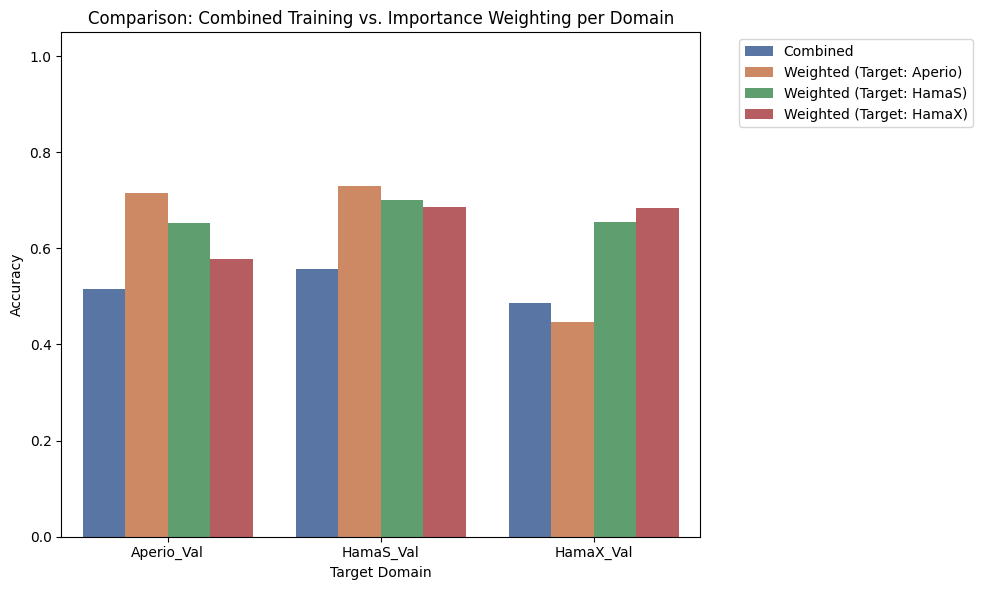

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def visualize_weighted_vs_combined(baseline_df, weighted_models, weighted_model_names, loaders, evaluate_func):
    """
    Evaluates weighted models, combines results with baseline Combined model stats,
    and plots a comparison.
    """
    # 1. Evaluate the new weighted models on all domains
    print("\nEvaluating Weighted Models on Individual Validation Sets...")
    weighted_results_df = generate_cross_domain_matrix(
        models=weighted_models,
        model_names=weighted_model_names,
        aperio_loaders=loaders['Aperio'],
        hamaS_loaders=loaders['HamaS'],
        hamaX_loaders=loaders['HamaX'],
        evaluate_func=evaluate_func,
        splits_to_evaluate=['Val']
    )

    # 2. Extract the 'Combined' row from the baseline dataframe (final_df)
    # We look for rows named 'Combined'. If multiple exist, we take the last one (most recent).
    if 'Combined' in baseline_df.index:
        combined_row = baseline_df.loc[['Combined']].tail(1)
    elif 'Combined (Early Stopping)' in baseline_df.index:
         combined_row = baseline_df.loc[['Combined (Early Stopping)']].tail(1)
    else:
        # Fallback if specific row not found, just take the last row assuming it's the combined one
        combined_row = baseline_df.tail(1)
        combined_row.index = ['Combined (Baseline)']

    # 3. Combine DataFrames
    comparison_df = pd.concat([combined_row, weighted_results_df])

    print("\n--- Performance Comparison Matrix ---")
    display(comparison_df.round(4))

    # 4. Plotting
    # Reshape for Seaborn: Index -> 'Model', Columns -> 'Domain', Values -> 'Accuracy'
    plot_df = comparison_df.reset_index().melt(id_vars='index', var_name='Target Domain', value_name='Accuracy')
    plot_df = plot_df.rename(columns={'index': 'Training Strategy'})

    plt.figure(figsize=(10, 6))
    sns.barplot(data=plot_df, x='Target Domain', y='Accuracy', hue='Training Strategy', palette='deep')
    plt.title("Comparison: Combined Training vs. Importance Weighting per Domain")
    plt.ylim(0, 1.05)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('weighted_training_comparison.png')
    print("Comparison plot saved to 'weighted_training_comparison.png'")

# Prepare inputs for the function
all_loaders_dict = {
    'Aperio': aperio_loaders,
    'HamaS': hamaS_loaders,
    'HamaX': hamaX_loaders
}

weighted_models_list = [weighted_model_aperio, weighted_model_hamaS, weighted_model_hamaX]
weighted_names_list = ['Weighted (Target: Aperio)', 'Weighted (Target: HamaS)', 'Weighted (Target: HamaX)']

# Execute
visualize_weighted_vs_combined(
    baseline_df=final_df,
    weighted_models=weighted_models_list,
    weighted_model_names=weighted_names_list,
    loaders=all_loaders_dict,
    evaluate_func=evaluate
)

Experiment 3

In [39]:
amc_filters = {
    'Tumor': 'canine soft tissue sarcoma',
    'Scanner': '3D Histech',
    'Origin': 'AMC New York'
}

amc_train_loader, amc_val_loader, amc_test_loader = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=amc_filters,
    train_transform=train_transforms_combined,
    eval_transform=eval_transforms_deterministic,
    final_train=False
)



--- Data Split Summary ---
Original Total Annotations: 3169
Train Annotations: 2217 (70.0%)
Validation Annotations: 476 (15.0%)
Test Annotations: 476 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32


In [41]:
vmu_filters = {
    'Tumor': 'canine soft tissue sarcoma',
    'Scanner': '3D Histech',
    'Origin': 'VMU Vienna'
}

# Create all loaders for VMU Vienna first
vmu_train_split_loader, vmu_val_split_loader, vmu_test_split_loader = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=vmu_filters,
    train_transform=train_transforms_combined,
    eval_transform=eval_transforms_deterministic,
    final_train=False
)

# Combine all splits of VMU data into a single dataset for full validation
from torch.utils.data import ConcatDataset, DataLoader
vmu_full_dataset = ConcatDataset([
    vmu_train_split_loader.dataset,
    vmu_val_split_loader.dataset,
    vmu_test_split_loader.dataset
])

# Create a DataLoader for the entire VMU dataset for validation
vmu_full_validation_loader = DataLoader(
    vmu_full_dataset,
    batch_size=32,
    shuffle=False, # No need to shuffle for validation
    drop_last=False
)

print(f"Full VMU Validation Dataset Size: {len(vmu_full_dataset)}")
print(f"Full VMU Validation Loader batch size: {vmu_full_validation_loader.batch_size}")


--- Data Split Summary ---
Original Total Annotations: 492
Train Annotations: 344 (69.9%)
Validation Annotations: 74 (15.0%)
Test Annotations: 74 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32
Full VMU Validation Dataset Size: 492
Full VMU Validation Loader batch size: 32


Epoch 0 (Initial): Train Acc = 0.5679, Test Acc = 0.5588
Epoch 10: Train Acc = 0.7298, Test Acc = 0.7059
Epoch 20: Train Acc = 0.7781, Test Acc = 0.7563
Epoch 30: Train Acc = 0.7790, Test Acc = 0.7521
Epoch 40: Train Acc = 0.8214, Test Acc = 0.7395
Epoch 50: Train Acc = 0.8570, Test Acc = 0.7500


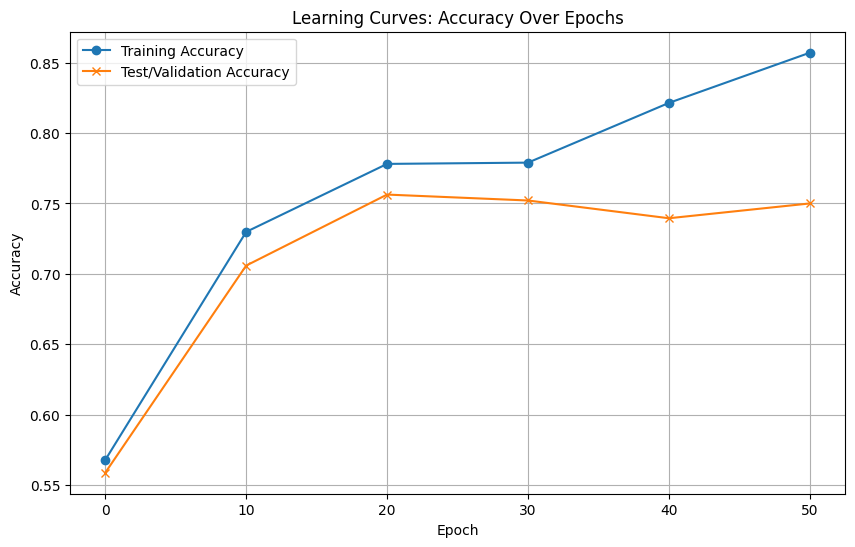


Training Complete. Final Train Acc: 0.8570, Final Test Acc: 0.7500

Model trained on AMC New York Data:
  Final Train Accuracy (AMC): 0.8570
  Final Validation Accuracy (AMC): 0.7500


In [42]:
model_amc_trained = lenet5_relu_max_dropout_bn()
trainacc_amc, valacc_amc = train_CNN(model_amc_trained, amc_train_loader, amc_val_loader, num_epochs=50)

print(f"\nModel trained on AMC New York Data:")
print(f"  Final Train Accuracy (AMC): {trainacc_amc:.4f}")
print(f"  Final Validation Accuracy (AMC): {valacc_amc:.4f}")


In [43]:
# Evaluate the AMC-trained model on the AMC validation set
_, amc_val_accuracy = evaluate(model_amc_trained, amc_train_loader, amc_val_loader, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Evaluate the AMC-trained model on the VMU full validation set
_, vmu_full_val_accuracy = evaluate(model_amc_trained, amc_train_loader, vmu_full_validation_loader, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


print(f"\nEvaluation of Model trained on AMC New York Data:")
print(f"  Validation Accuracy on AMC New York: {amc_val_accuracy:.4f}")
print(f"  Validation Accuracy on VMU Vienna (Full Dataset): {vmu_full_val_accuracy:.4f}")

# Store these accuracies for potential later use (e.g., in a cross-domain matrix)
amc_vmu_evaluation_results = {
    "AMC New York_Val": amc_val_accuracy,
    "VMU Vienna_FullVal": vmu_full_val_accuracy
}

# You can print or store this in a DataFrame as needed
print(f"\nCombined Evaluation Results: {amc_vmu_evaluation_results}")


Evaluation of Model trained on AMC New York Data:
  Validation Accuracy on AMC New York: 0.7500
  Validation Accuracy on VMU Vienna (Full Dataset): 0.6443

Combined Evaluation Results: {'AMC New York_Val': 0.75, 'VMU Vienna_FullVal': 0.6443089430894309}


In [45]:
# Define new aggressive brightness augmentation
agg_brightness_aug_combined = transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.4)

# Define new aggressive combined train transforms
train_transforms_combined_agg = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),
    agg_brightness_aug_combined,
    transforms.ToTensor(),
])

# Create new AMC loaders with aggressive augmentation
print("Creating new AMC loaders with aggressive augmentation...")
amc_train_loader_agg, amc_val_loader_agg, amc_test_loader_agg = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=amc_filters,
    train_transform=train_transforms_combined_agg,
    eval_transform=eval_transforms_deterministic,
    final_train=False
)

print("New AMC loaders with aggressive augmentation created.")

Creating new AMC loaders with aggressive augmentation...

--- Data Split Summary ---
Original Total Annotations: 3169
Train Annotations: 2217 (70.0%)
Validation Annotations: 476 (15.0%)
Test Annotations: 476 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32
New AMC loaders with aggressive augmentation created.


Training new model with aggressively augmented AMC data...
Epoch 0 (Initial): Train Acc = 0.3478, Test Acc = 0.3466
Epoch 10: Train Acc = 0.6942, Test Acc = 0.6849
Epoch 20: Train Acc = 0.6856, Test Acc = 0.6996
Epoch 30: Train Acc = 0.6919, Test Acc = 0.7164
Epoch 40: Train Acc = 0.7050, Test Acc = 0.6954
Epoch 50: Train Acc = 0.7073, Test Acc = 0.6891


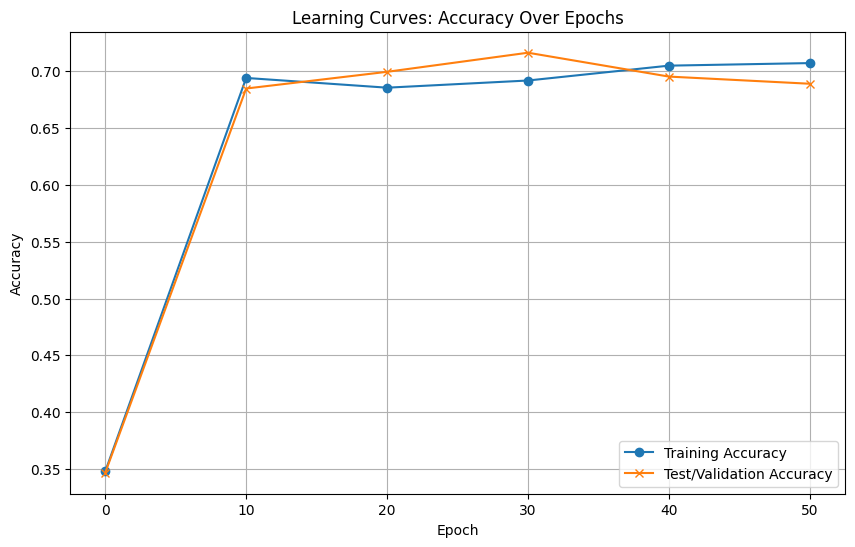


Training Complete. Final Train Acc: 0.7073, Final Test Acc: 0.6891

Model trained on Aggressively Augmented AMC New York Data:
  Final Train Accuracy (AMC Agg): 0.7073
  Final Validation Accuracy (AMC Agg): 0.6891


In [46]:
# Train a new model with the aggressively augmented AMC data
print("Training new model with aggressively augmented AMC data...")
model_amc_trained_agg = lenet5_relu_max_dropout_bn()
trainacc_amc_agg, valacc_amc_agg = train_CNN(model_amc_trained_agg, amc_train_loader_agg, amc_val_loader_agg, num_epochs=50)

print(f"\nModel trained on Aggressively Augmented AMC New York Data:")
print(f"  Final Train Accuracy (AMC Agg): {trainacc_amc_agg:.4f}")
print(f"  Final Validation Accuracy (AMC Agg): {valacc_amc_agg:.4f}")

In [47]:
# Evaluate the aggressively trained AMC model on the new AMC validation set
_, amc_val_accuracy_agg = evaluate(model_amc_trained_agg, amc_train_loader_agg, amc_val_loader_agg, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Evaluate the aggressively trained AMC model on the VMU full validation set
_, vmu_full_val_accuracy_agg = evaluate(model_amc_trained_agg, amc_train_loader_agg, vmu_full_validation_loader, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


print(f"\nEvaluation of Model trained on Aggressively Augmented AMC New York Data:")
print(f"  Validation Accuracy on AMC New York (Agg): {amc_val_accuracy_agg:.4f}")
print(f"  Validation Accuracy on VMU Vienna (Full Dataset) (Agg): {vmu_full_val_accuracy_agg:.4f}")

# Store these accuracies
amc_vmu_evaluation_results_agg = {
    "AMC New York_Val (Agg)": amc_val_accuracy_agg,
    "VMU Vienna_FullVal (Agg)": vmu_full_val_accuracy_agg
}

print(f"\nCombined Evaluation Results (Agg): {amc_vmu_evaluation_results_agg}")


Evaluation of Model trained on Aggressively Augmented AMC New York Data:
  Validation Accuracy on AMC New York (Agg): 0.6891
  Validation Accuracy on VMU Vienna (Full Dataset) (Agg): 0.6362

Combined Evaluation Results (Agg): {'AMC New York_Val (Agg)': 0.6890756302521008, 'VMU Vienna_FullVal (Agg)': 0.6361788617886179}


## Define Individual Aggressive Augmentations

### Subtask:
Define three new sets of image transformations, each applying an aggressive level of only one type of jitter: brightness, saturation, or hue. All other jitter parameters will be set to 0 to isolate the effect of each specific augmentation.


In [65]:
import torchvision.transforms as transforms

# 1. Define individual aggressive augmentations
brightness_aug_aggressive = transforms.ColorJitter(brightness=0.8, contrast=0.0, saturation=0.0, hue=0.0)
saturation_aug_aggressive = transforms.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.8, hue=0.0)
hue_aug_aggressive = transforms.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.4)

# 2. Create new training transform pipelines for each aggressive augmentation
train_transforms_brightness = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),
    brightness_aug_aggressive,
    transforms.ToTensor(),
])

train_transforms_saturation = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),
    saturation_aug_aggressive,
    transforms.ToTensor(),
])

train_transforms_hue = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),
    hue_aug_aggressive,
    transforms.ToTensor(),
])

print("Aggressive individual augmentation transforms defined.")

Aggressive individual augmentation transforms defined.


## Train Models with Individual Aggressive Augmentations

### Subtask:
Train three separate `lenet5_relu_max_dropout_bn` models. Each model will be trained on the AMC New York training data that has been aggressively augmented with only brightness, saturation, or hue jitter, respectively. Each model will be trained for 50 epochs.


In [68]:
import torchvision.transforms as transforms

# 1. Define individual aggressive augmentations
brightness_aug_aggressive = transforms.ColorJitter(brightness=0.8, contrast=0.0, saturation=0.0, hue=0.0)
contrast_aug_aggressive = transforms.ColorJitter(brightness=0.0, contrast=0.8, saturation=0.0, hue=0.0)
saturation_aug_aggressive = transforms.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.8, hue=0.0)
hue_aug_aggressive = transforms.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.4)

# 2. Create new training transform pipelines for each aggressive augmentation
train_transforms_brightness = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),
    brightness_aug_aggressive,
    transforms.ToTensor(),
])

train_transforms_contrast = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),
    contrast_aug_aggressive,
    transforms.ToTensor(),
])

train_transforms_saturation = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),
    saturation_aug_aggressive,
    transforms.ToTensor(),
])

train_transforms_hue = transforms.Compose([
    transforms.CenterCrop(TARGET_SIZE),
    transforms.RandomHorizontalFlip(p=0.50),
    transforms.RandomVerticalFlip(p=0.5),
    hue_aug_aggressive,
    transforms.ToTensor(),
])

print("Aggressive individual augmentation transforms defined.")

Aggressive individual augmentation transforms defined.


## Create DataLoaders for Each Augmentation Type

### Subtask:
Generate new AMC New York training and validation DataLoaders for each of the aggressively augmented transform sets (brightness, contrast, saturation, and hue). This ensures that each model is trained on data with a distinct type of aggressive augmentation.


In [69]:
print("Creating AMC loaders for brightness augmentation...")
amc_train_loader_brightness, amc_val_loader_brightness, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=amc_filters,
    train_transform=train_transforms_brightness,
    eval_transform=eval_transforms_deterministic,
    final_train=False # Always generate train/val/test splits
)

print("Creating AMC loaders for contrast augmentation...")
amc_train_loader_contrast, amc_val_loader_contrast, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=amc_filters,
    train_transform=train_transforms_contrast,
    eval_transform=eval_transforms_deterministic,
    final_train=False
)

print("Creating AMC loaders for saturation augmentation...")
amc_train_loader_saturation, amc_val_loader_saturation, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=amc_filters,
    train_transform=train_transforms_saturation,
    eval_transform=eval_transforms_deterministic,
    final_train=False
)

print("Creating AMC loaders for hue augmentation...")
amc_train_loader_hue, amc_val_loader_hue, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=amc_filters,
    train_transform=train_transforms_hue,
    eval_transform=eval_transforms_deterministic,
    final_train=False
)

print("All aggressively augmented AMC loaders created successfully.")

Creating AMC loaders for brightness augmentation...

--- Data Split Summary ---
Original Total Annotations: 3169
Train Annotations: 2217 (70.0%)
Validation Annotations: 476 (15.0%)
Test Annotations: 476 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32
Creating AMC loaders for contrast augmentation...

--- Data Split Summary ---
Original Total Annotations: 3169
Train Annotations: 2217 (70.0%)
Validation Annotations: 476 (15.0%)
Test Annotations: 476 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32
Creating AMC loaders for saturation augmentation...

--- Data Split Summary ---
Original Total Annotations: 3169
Train Annotations: 2217 (70.0%)
Validation Annotations: 476 (15.0%)
Test Annotations: 476 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32
Creating AMC loaders for hue augmentation...

--- Data Split Summary ---
Original Total Annotations: 3169
Train Annotations: 2217 (70.0%)
Validation Annotations: 476 (15.0%)
Test A

Training model with brightness augmentation...
Epoch 0 (Initial): Train Acc = 0.6198, Test Acc = 0.6492
Epoch 10: Train Acc = 0.7388, Test Acc = 0.7101
Epoch 20: Train Acc = 0.7452, Test Acc = 0.7017
Epoch 30: Train Acc = 0.7839, Test Acc = 0.7563
Epoch 40: Train Acc = 0.7564, Test Acc = 0.7332
Epoch 50: Train Acc = 0.7988, Test Acc = 0.7437


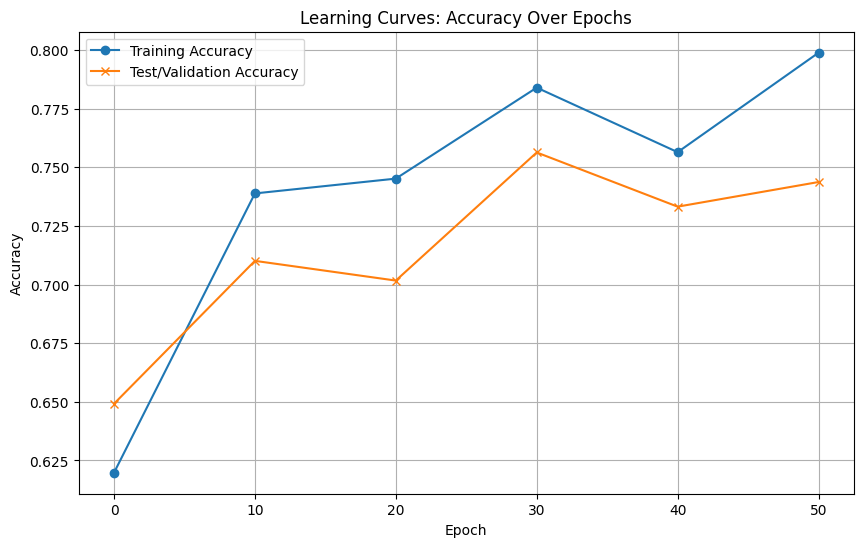


Training Complete. Final Train Acc: 0.7988, Final Test Acc: 0.7437

Training model with contrast augmentation...
Epoch 0 (Initial): Train Acc = 0.6540, Test Acc = 0.6534
Epoch 10: Train Acc = 0.7673, Test Acc = 0.7479
Epoch 20: Train Acc = 0.7533, Test Acc = 0.7185
Epoch 30: Train Acc = 0.8006, Test Acc = 0.7668
Epoch 40: Train Acc = 0.8295, Test Acc = 0.7794
Epoch 50: Train Acc = 0.8281, Test Acc = 0.7773


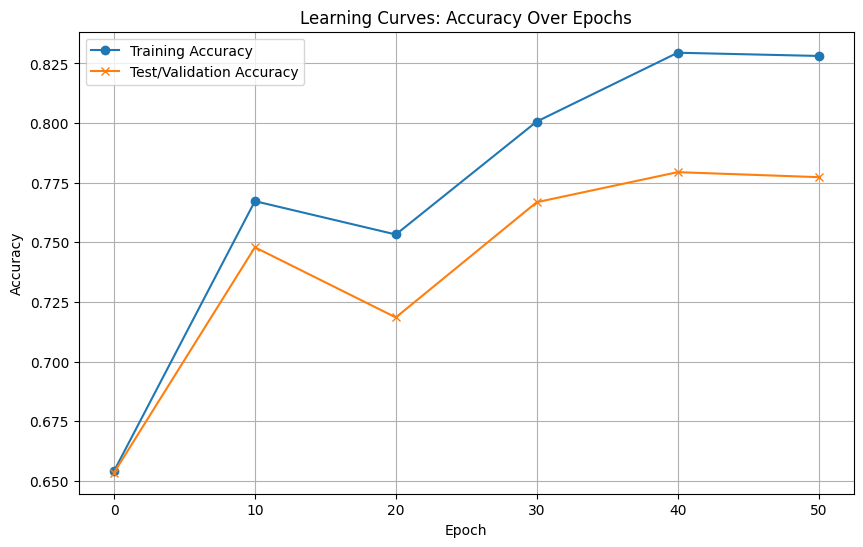


Training Complete. Final Train Acc: 0.8281, Final Test Acc: 0.7773

Training model with saturation augmentation...
Epoch 0 (Initial): Train Acc = 0.6540, Test Acc = 0.6534
Epoch 10: Train Acc = 0.6973, Test Acc = 0.6891
Epoch 20: Train Acc = 0.7474, Test Acc = 0.7353
Epoch 30: Train Acc = 0.8250, Test Acc = 0.7521
Epoch 40: Train Acc = 0.8521, Test Acc = 0.7395
Epoch 50: Train Acc = 0.8863, Test Acc = 0.7605


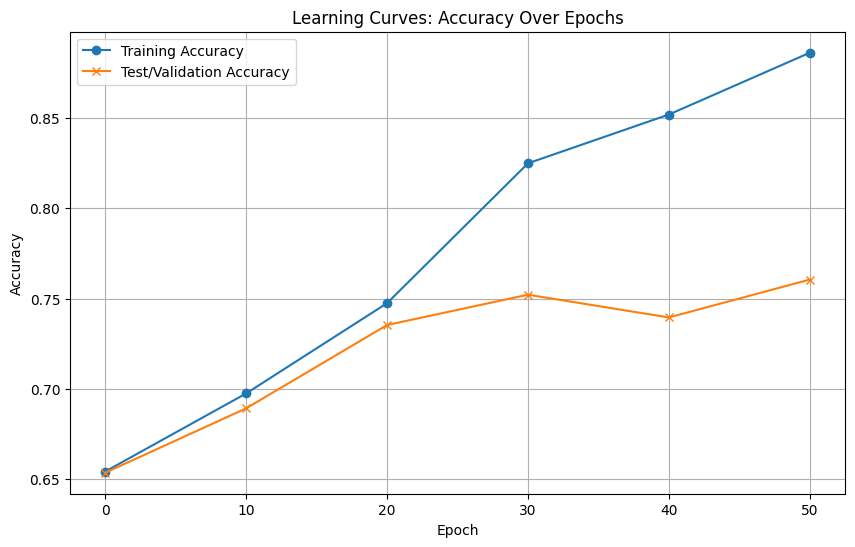


Training Complete. Final Train Acc: 0.8863, Final Test Acc: 0.7605

Training model with hue augmentation...
Epoch 0 (Initial): Train Acc = 0.3460, Test Acc = 0.3466
Epoch 10: Train Acc = 0.7483, Test Acc = 0.7332
Epoch 20: Train Acc = 0.7817, Test Acc = 0.7563
Epoch 30: Train Acc = 0.8042, Test Acc = 0.7563
Epoch 40: Train Acc = 0.8119, Test Acc = 0.7731
Epoch 50: Train Acc = 0.7812, Test Acc = 0.7248


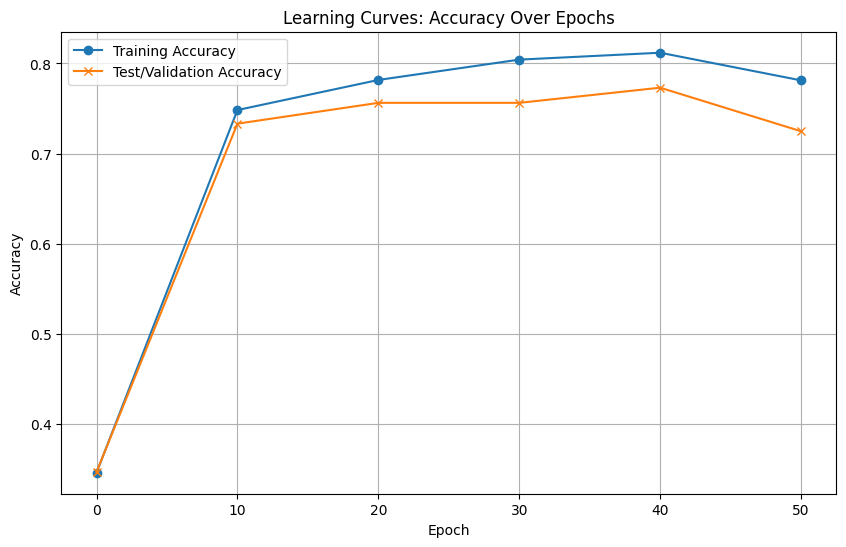


Training Complete. Final Train Acc: 0.7812, Final Test Acc: 0.7248
All models trained with individual aggressive augmentations.


In [72]:
print("Training model with brightness augmentation...")
model_amc_brightness = lenet5_relu_max_dropout_bn()
trainacc_amc_brightness, valacc_amc_brightness = train_CNN(model_amc_brightness, amc_train_loader_brightness, amc_val_loader_brightness, num_epochs=50)

print("\nTraining model with contrast augmentation...")
model_amc_contrast = lenet5_relu_max_dropout_bn()
trainacc_amc_contrast, valacc_amc_contrast = train_CNN(model_amc_contrast, amc_train_loader_contrast, amc_val_loader_contrast, num_epochs=50)

print("\nTraining model with saturation augmentation...")
model_amc_saturation = lenet5_relu_max_dropout_bn()
trainacc_amc_saturation, valacc_amc_saturation = train_CNN(model_amc_saturation, amc_train_loader_saturation, amc_val_loader_saturation, num_epochs=50)

print("\nTraining model with hue augmentation...")
model_amc_hue = lenet5_relu_max_dropout_bn()
trainacc_amc_hue, valacc_amc_hue = train_CNN(model_amc_hue, amc_train_loader_hue, amc_val_loader_hue, num_epochs=50)

print("All models trained with individual aggressive augmentations.")

## Evaluate and Collect Results

### Subtask:
Evaluate each of the five models (baseline and four aggressively augmented models) on both the AMC New York validation set and the full VMU Vienna validation set. Collect these results in a structured format for comparison.


In [73]:
import pandas as pd
import torch

# 1. Initialize an empty dictionary
augmentation_evaluation_results = {}

# 2. Get the evaluation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3. Evaluate the model_amc_trained (baseline model)
_, amc_val_acc_baseline = evaluate(model_amc_trained, amc_train_loader, amc_val_loader, device=device)
_, vmu_full_val_acc_baseline = evaluate(model_amc_trained, amc_train_loader, vmu_full_validation_loader, device=device)
augmentation_evaluation_results['Baseline'] = {'AMC_Val': amc_val_acc_baseline, 'VMU_FullVal': vmu_full_val_acc_baseline}

print(f"Evaluated Baseline model: AMC_Val={amc_val_acc_baseline:.4f}, VMU_FullVal={vmu_full_val_acc_baseline:.4f}")

# 4. Evaluate model_amc_brightness
_, amc_val_acc_brightness = evaluate(model_amc_brightness, amc_train_loader_brightness, amc_val_loader_brightness, device=device)
_, vmu_full_val_acc_brightness = evaluate(model_amc_brightness, amc_train_loader_brightness, vmu_full_validation_loader, device=device)
augmentation_evaluation_results['Brightness_Aug'] = {'AMC_Val': amc_val_acc_brightness, 'VMU_FullVal': vmu_full_val_acc_brightness}

print(f"Evaluated Brightness_Aug model: AMC_Val={amc_val_acc_brightness:.4f}, VMU_FullVal={vmu_full_val_acc_brightness:.4f}")

# 5. Evaluate model_amc_contrast
_, amc_val_acc_contrast = evaluate(model_amc_contrast, amc_train_loader_contrast, amc_val_loader_contrast, device=device)
_, vmu_full_val_acc_contrast = evaluate(model_amc_contrast, amc_train_loader_contrast, vmu_full_validation_loader, device=device)
augmentation_evaluation_results['Contrast_Aug'] = {'AMC_Val': amc_val_acc_contrast, 'VMU_FullVal': vmu_full_val_acc_contrast}

print(f"Evaluated Contrast_Aug model: AMC_Val={amc_val_acc_contrast:.4f}, VMU_FullVal={vmu_full_val_acc_contrast:.4f}")

# 6. Evaluate model_amc_saturation
_, amc_val_acc_saturation = evaluate(model_amc_saturation, amc_train_loader_saturation, amc_val_loader_saturation, device=device)
_, vmu_full_val_acc_saturation = evaluate(model_amc_saturation, amc_train_loader_saturation, vmu_full_validation_loader, device=device)
augmentation_evaluation_results['Saturation_Aug'] = {'AMC_Val': amc_val_acc_saturation, 'VMU_FullVal': vmu_full_val_acc_saturation}

print(f"Evaluated Saturation_Aug model: AMC_Val={amc_val_acc_saturation:.4f}, VMU_FullVal={vmu_full_val_acc_saturation:.4f}")

# 7. Evaluate model_amc_hue
_, amc_val_acc_hue = evaluate(model_amc_hue, amc_train_loader_hue, amc_val_loader_hue, device=device)
_, vmu_full_val_acc_hue = evaluate(model_amc_hue, amc_train_loader_hue, vmu_full_validation_loader, device=device)
augmentation_evaluation_results['Hue_Aug'] = {'AMC_Val': amc_val_acc_hue, 'VMU_FullVal': vmu_full_val_acc_hue}

print(f"Evaluated Hue_Aug model: AMC_Val={amc_val_acc_hue:.4f}, VMU_FullVal={vmu_full_val_acc_hue:.4f}")

# 8. Convert the results to a Pandas DataFrame and display it
augmentation_df = pd.DataFrame.from_dict(augmentation_evaluation_results, orient='index')
print("\n--- Augmentation Evaluation Results ---")
display(augmentation_df.round(4))


Evaluated Baseline model: AMC_Val=0.7500, VMU_FullVal=0.6789
Evaluated Brightness_Aug model: AMC_Val=0.7437, VMU_FullVal=0.6402
Evaluated Contrast_Aug model: AMC_Val=0.7773, VMU_FullVal=0.6179
Evaluated Saturation_Aug model: AMC_Val=0.7605, VMU_FullVal=0.6545
Evaluated Hue_Aug model: AMC_Val=0.7248, VMU_FullVal=0.6585

--- Augmentation Evaluation Results ---


,AMC_Val,VMU_FullVal
Baseline,0.7500,0.6789
Brightness_Aug,0.7437,0.6402
Contrast_Aug,0.7773,0.6179
Saturation_Aug,0.7605,0.6545
Hue_Aug,0.7248,0.6585


Comparison bar plot saved to 'augmentation_comparison_bar_plot.png'


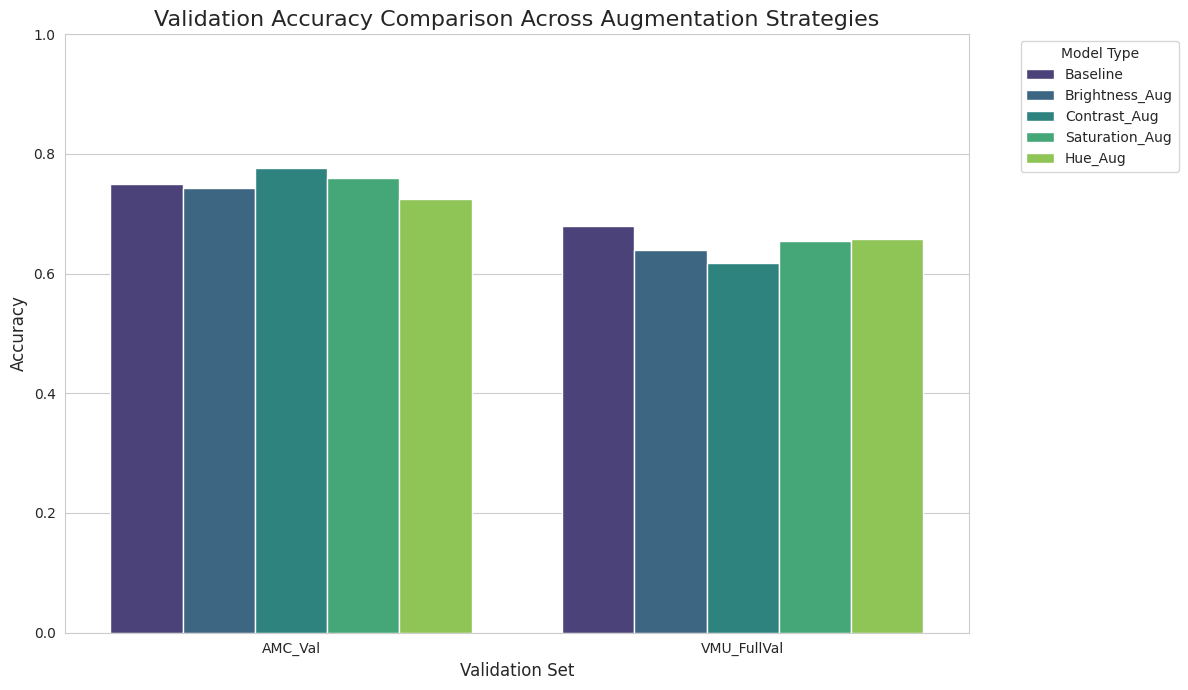

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the DataFrame for plotting with Seaborn
# Melt the DataFrame to have 'Metric' and 'Value' columns for easy plotting
plot_df_aug = augmentation_df.reset_index().melt(id_vars='index', var_name='Validation Set', value_name='Accuracy')
plot_df_aug = plot_df_aug.rename(columns={'index': 'Model'})

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=plot_df_aug, x='Validation Set', y='Accuracy', hue='Model', palette='viridis')

# Add titles and labels
plt.title('Validation Accuracy Comparison Across Augmentation Strategies', fontsize=16)
plt.xlabel('Validation Set', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.0)

# Place the legend outside the plot for better readability
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model Type')

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Save the plot to a file
plt.savefig('augmentation_comparison_bar_plot.png')
print("Comparison bar plot saved to 'augmentation_comparison_bar_plot.png'")

# Display the plot
plt.show()

# Task
Identify the unique 'Tumor' entries in the `df_master` DataFrame where 'Origin' is 'VMU Vienna' and 'Scanner' is '3D Histech', excluding the target 'canine soft tissue sarcoma', to determine the source domains for the Meta-Learning Domain Generalization (MLDG) experiment.

In [75]:
# 1. Filter df_master for VMU Vienna and 3D Histech
vmu_3dhistech_df = df_master[
    (df_master['Origin'] == 'VMU Vienna') &
    (df_master['Scanner'] == '3D Histech')
]

# 2. Extract unique tumor types
unique_tumors = vmu_3dhistech_df['Tumor'].unique()

# 3. Exclude 'canine soft tissue sarcoma'
available_tumors = [t for t in unique_tumors if t != 'canine soft tissue sarcoma']

# 4. Print the remaining tumor types
print("Available tumor types in VMU Vienna (3D Histech) excluding 'canine soft tissue sarcoma':")
for tumor in available_tumors:
    print(f"- {tumor}")

if not available_tumors:
    print("No other tumor types found matching the criteria.")

Available tumor types in VMU Vienna (3D Histech) excluding 'canine soft tissue sarcoma':
- canine lung cancer
- canine lymphoma


## Create Domain DataLoaders

### Subtask:
Create distinct DataLoaders for the three source domains: AMC New York (Sarcoma), VMU Vienna (Lung Cancer), and VMU Vienna (Lymphoma).


In [76]:
# 1. Define filters for MLDG source domains
amc_sarcoma_filters = {'Tumor': 'canine soft tissue sarcoma', 'Scanner': '3D Histech', 'Origin': 'AMC New York'}
vmu_lung_filters = {'Tumor': 'canine lung cancer', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}
vmu_lymphoma_filters = {'Tumor': 'canine lymphoma', 'Scanner': '3D Histech', 'Origin': 'VMU Vienna'}

# 2. Create DataLoaders for each domain
print("Creating loaders for AMC Sarcoma...")
amc_sarcoma_train_loader, amc_sarcoma_val_loader, amc_sarcoma_test_loader = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=amc_sarcoma_filters,
    train_transform=train_transforms_combined,
    eval_transform=eval_transforms_deterministic,
    final_train=False
)

print("Creating loaders for VMU Lung Cancer...")
vmu_lung_train_loader, vmu_lung_val_loader, vmu_lung_test_loader = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=vmu_lung_filters,
    train_transform=train_transforms_combined,
    eval_transform=eval_transforms_deterministic,
    final_train=False
)

print("Creating loaders for VMU Lymphoma...")
vmu_lymphoma_train_loader, vmu_lymphoma_val_loader, vmu_lymphoma_test_loader = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=vmu_lymphoma_filters,
    train_transform=train_transforms_combined,
    eval_transform=eval_transforms_deterministic,
    final_train=False
)

# 3. Collect training loaders for MLDG loop
mldg_source_loaders = [amc_sarcoma_train_loader, vmu_lung_train_loader, vmu_lymphoma_train_loader]
print(f"Created {len(mldg_source_loaders)} source domain loaders for MLDG training.")

Creating loaders for AMC Sarcoma...

--- Data Split Summary ---
Original Total Annotations: 3169
Train Annotations: 2217 (70.0%)
Validation Annotations: 476 (15.0%)
Test Annotations: 476 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32
Creating loaders for VMU Lung Cancer...

--- Data Split Summary ---
Original Total Annotations: 1806
Train Annotations: 1264 (70.0%)
Validation Annotations: 271 (15.0%)
Test Annotations: 271 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32
Creating loaders for VMU Lymphoma...

--- Data Split Summary ---
Original Total Annotations: 8216
Train Annotations: 5750 (70.0%)
Validation Annotations: 1233 (15.0%)
Test Annotations: 1233 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32
Created 3 source domain loaders for MLDG training.


## Implement MLDG Training Loop

### Subtask:
Define the `train_mldg` function to train the model using a Meta-Learning Domain Generalization approach (First-Order Approximation).


In [77]:
from copy import deepcopy
import torch.optim as optim
import torch
import random

def train_mldg(model, source_loaders, val_loader, num_epochs=30, lr=0.001, meta_step_size=0.01, meta_beta=1.0, device=None):
    """
    Trains a model using Meta-Learning Domain Generalization (First-Order Approximation).
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    print(f"Starting MLDG training on {device}...")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        steps = 0

        # Create iterators for all source loaders
        iterators = [iter(loader) for loader in source_loaders]
        # We iterate based on the length of the shortest loader to ensure we can zip batches
        min_batches = min([len(l) for l in source_loaders])

        for _ in range(min_batches):
            # Fetch one batch from each domain
            domain_batches = [next(it) for it in iterators]

            # i. Randomly select Meta-Test domain
            num_domains = len(source_loaders)
            test_idx = random.randint(0, num_domains - 1)
            train_indices = [i for i in range(num_domains) if i != test_idx]

            # ii. Meta-Train Step
            meta_train_loss = 0.0
            optimizer.zero_grad()

            for i in train_indices:
                batch = domain_batches[i]
                # Robust unpacking of batch
                if isinstance(batch, dict):
                     inputs, targets = batch['image'], batch['label']
                elif isinstance(batch, (list, tuple)):
                     inputs, targets = batch[0], batch[1]
                else:
                     inputs, targets = batch[0], batch[1]

                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                meta_train_loss += loss

            # Normalize loss (optional, but good practice)
            meta_train_loss = meta_train_loss / len(train_indices)

            # Compute gradients of meta_train_loss w.r.t original model
            # retain_graph=True is crucial because we will backprop on this loss again later
            grads = torch.autograd.grad(meta_train_loss, model.parameters(), create_graph=False, retain_graph=True)

            # iii. Inner Update (Create temporary model)
            temp_model = deepcopy(model)
            # Manually update temp model parameters (Simulate SGD step)
            with torch.no_grad():
                for param, grad in zip(temp_model.parameters(), grads):
                    if grad is not None:
                        param.data = param.data - meta_step_size * grad.data

            # iv. Meta-Test Step
            test_batch = domain_batches[test_idx]
            if isinstance(test_batch, dict):
                 inputs_test, targets_test = test_batch['image'], test_batch['label']
            elif isinstance(test_batch, (list, tuple)):
                 inputs_test, targets_test = test_batch[0], test_batch[1]
            else:
                 inputs_test, targets_test = test_batch[0], test_batch[1]

            inputs_test, targets_test = inputs_test.to(device), targets_test.to(device)
            outputs_test = temp_model(inputs_test)
            meta_test_loss = criterion(outputs_test, targets_test)

            # v. Meta-Optimization (First-Order Approximation)
            # 1. Populate gradients on original model from Meta-Train Loss
            meta_train_loss.backward()

            # 2. Get gradients from Meta-Test Loss (on temp model)
            temp_model.zero_grad()
            meta_test_loss.backward()

            # 3. Add scaled Meta-Test gradients to original model's gradients
            with torch.no_grad():
                for param, temp_param in zip(model.parameters(), temp_model.parameters()):
                    if param.grad is not None and temp_param.grad is not None:
                        param.grad.add_(temp_param.grad * meta_beta)

            # vi. Optimizer Step
            optimizer.step()
            optimizer.zero_grad()

            running_loss += meta_train_loss.item() + meta_test_loss.item()
            steps += 1

        # c. Evaluate on val_loader
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                if isinstance(batch, dict):
                     inputs, targets = batch['image'], batch['label']
                elif isinstance(batch, (list, tuple)):
                     inputs, targets = batch[0], batch[1]
                else:
                     inputs, targets = batch[0], batch[1]

                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        val_acc = correct / total if total > 0 else 0.0
        print(f"Epoch {epoch+1}/{num_epochs}: Avg Loss={running_loss/steps:.4f}, Val Acc={val_acc:.4f}")

    return model

In [80]:
# 1. Instantiate a new model for MLDG
mldg_model = lenet5_relu_max_dropout_bn()

# 2. Train the model using the MLDG strategy
# Source domains: AMC Sarcoma, VMU Lung, VMU Lymphoma
# Target domain (Unseen): VMU Sarcoma (represented by vmu_full_validation_loader)
print("Starting MLDG training...")
mldg_model = train_mldg(
    model=mldg_model,
    source_loaders=mldg_source_loaders,
    val_loader=vmu_full_validation_loader, # Validate on unseen target domain
    num_epochs=30,
    lr=0.001,
    meta_step_size=0.01,
    meta_beta=1.0
)

# 3. Final evaluation on the unseen target domain
print("\nPerforming final evaluation on unseen target domain (VMU Sarcoma)...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We pass one of the source loaders as a dummy train_loader for the evaluate signature
_, mldg_val_acc = evaluate(
    mldg_model,
    mldg_source_loaders[0],
    vmu_full_validation_loader,
    device=device
)

print(f"Final MLDG Validation Accuracy on VMU Sarcoma: {mldg_val_acc:.4f}")

Starting MLDG training...
Starting MLDG training on cuda...
Epoch 1/30: Avg Loss=1.4390, Val Acc=0.6260
Epoch 2/30: Avg Loss=1.3515, Val Acc=0.6545
Epoch 3/30: Avg Loss=1.3252, Val Acc=0.6240
Epoch 4/30: Avg Loss=1.3202, Val Acc=0.6504
Epoch 5/30: Avg Loss=1.2992, Val Acc=0.6463
Epoch 6/30: Avg Loss=1.2793, Val Acc=0.6646
Epoch 7/30: Avg Loss=1.2655, Val Acc=0.6484
Epoch 8/30: Avg Loss=1.2653, Val Acc=0.6768
Epoch 9/30: Avg Loss=1.2526, Val Acc=0.6341
Epoch 10/30: Avg Loss=1.2470, Val Acc=0.6850
Epoch 11/30: Avg Loss=1.2524, Val Acc=0.6728
Epoch 12/30: Avg Loss=1.2321, Val Acc=0.6768
Epoch 13/30: Avg Loss=1.2091, Val Acc=0.7033
Epoch 14/30: Avg Loss=1.2080, Val Acc=0.7175
Epoch 15/30: Avg Loss=1.2066, Val Acc=0.6687
Epoch 16/30: Avg Loss=1.2108, Val Acc=0.6829
Epoch 17/30: Avg Loss=1.2204, Val Acc=0.6911
Epoch 18/30: Avg Loss=1.1908, Val Acc=0.6911
Epoch 19/30: Avg Loss=1.1946, Val Acc=0.7012
Epoch 20/30: Avg Loss=1.1665, Val Acc=0.6728
Epoch 21/30: Avg Loss=1.1927, Val Acc=0.6829
Epoc

## Prepare Naive Training Data

### Subtask:
Combine source datasets into a single loader for naive ERM training.


In [81]:
from torch.utils.data import ConcatDataset, DataLoader

# 1. Collect datasets from source loaders
source_datasets = [
    amc_sarcoma_train_loader.dataset,
    vmu_lung_train_loader.dataset,
    vmu_lymphoma_train_loader.dataset
]

# 2. Concatenate them into one dataset
naive_train_dataset = ConcatDataset(source_datasets)

# 3. Create the Naive DataLoader
naive_train_loader = DataLoader(
    naive_train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
)

print(f"Naive Training Dataset Size: {len(naive_train_dataset)}")

Naive Training Dataset Size: 9231


## Train Naive Model

### Subtask:
Train a naive baseline model on the combined source domains using standard ERM.


Starting Naive ERM training...
Epoch 0 (Initial): Train Acc = 0.4479, Test Acc = 0.3841
Epoch 10: Train Acc = 0.6816, Test Acc = 0.6972
Epoch 20: Train Acc = 0.7118, Test Acc = 0.6992
Epoch 30: Train Acc = 0.7373, Test Acc = 0.7114


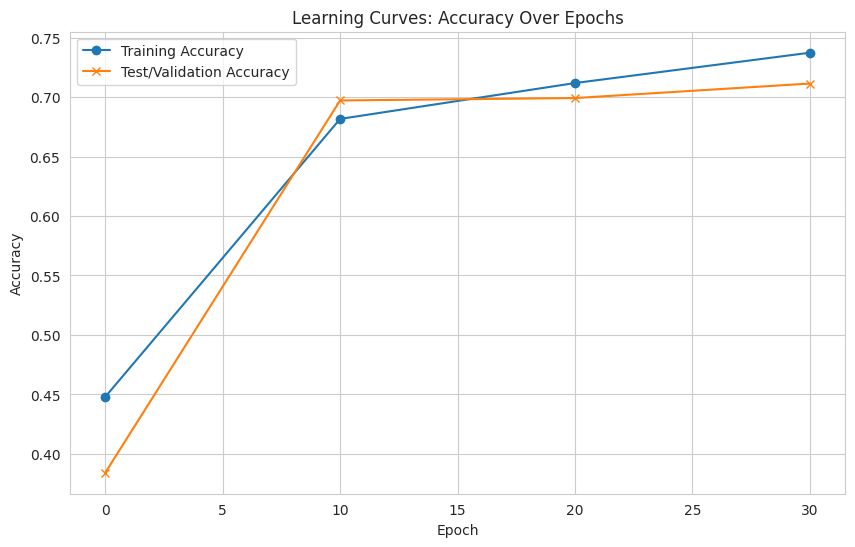


Training Complete. Final Train Acc: 0.7373, Final Test Acc: 0.7114

Naive Model - Final Train Acc: 0.7373
Naive Model - Final Validation Accuracy on VMU Sarcoma: 0.7114


In [83]:
# 1. Initialize a new model for Naive training
naive_model = lenet5_relu_max_dropout_bn()

# 2. Train using standard ERM (train_CNN)
# Training on combined source domains (naive_train_loader)
# Validating on unseen target domain (vmu_full_validation_loader)
print("Starting Naive ERM training...")
# Passing arguments positionally to avoid keyword argument mismatch
naive_train_acc, naive_val_acc = train_CNN(
    naive_model,
    naive_train_loader,
    vmu_full_validation_loader,
    num_epochs=30
)

print(f"\nNaive Model - Final Train Acc: {naive_train_acc:.4f}")
print(f"Naive Model - Final Validation Accuracy on VMU Sarcoma: {naive_val_acc:.4f}")

Corrected 'Seen' Validation Dataset Size: 1980

Evaluating Naive model on CORRECT combined validation set (3D Histech)...
Naive Model (True Seen Val): 0.7131
Evaluating MLDG model on CORRECT combined validation set (3D Histech)...
MLDG Model (True Seen Val): 0.6480


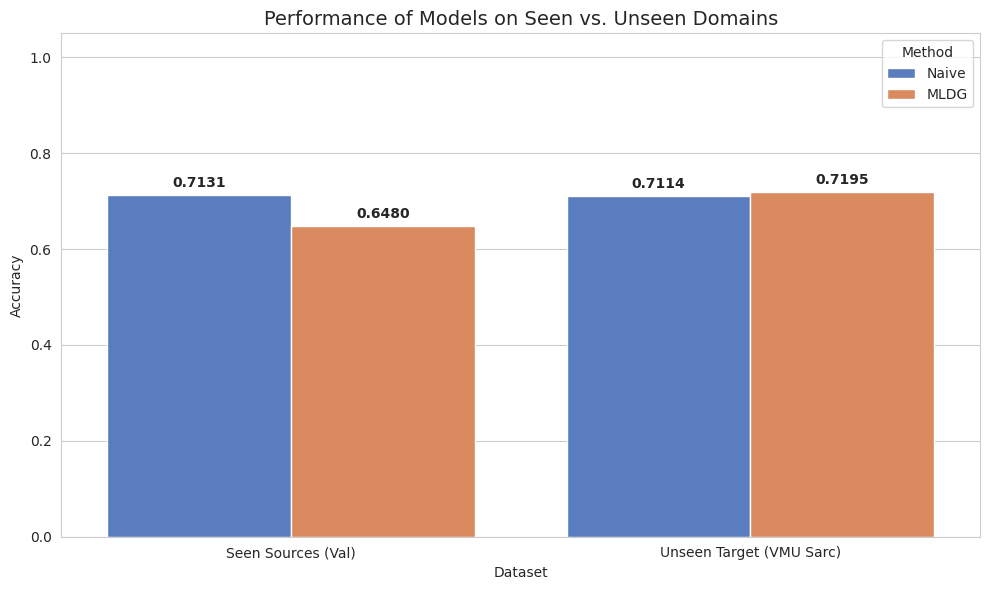

In [88]:
from torch.utils.data import ConcatDataset, DataLoader

# 1. Construct the CORRECT 'Seen' Validation Set
# These are the validation splits corresponding to the training domains
seen_val_datasets = [
    amc_sarcoma_val_loader.dataset,
    vmu_lung_val_loader.dataset,
    vmu_lymphoma_val_loader.dataset
]

# Combine them
mldg_seen_val_dataset = ConcatDataset(seen_val_datasets)
mldg_seen_val_loader = DataLoader(
    mldg_seen_val_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False
)

print(f"Corrected 'Seen' Validation Dataset Size: {len(mldg_seen_val_dataset)}")

# 2. Re-Evaluate Models on the CORRECT Seen Validation Set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("\nEvaluating Naive model on CORRECT combined validation set (3D Histech)...")
_, naive_seen_acc = evaluate(
    naive_model,
    naive_train_loader,
    mldg_seen_val_loader,
    device=device
)
print(f"Naive Model (True Seen Val): {naive_seen_acc:.4f}")

print("Evaluating MLDG model on CORRECT combined validation set (3D Histech)...")
_, mldg_seen_acc = evaluate(
    mldg_model,
    mldg_source_loaders[0],
    mldg_seen_val_loader,
    device=device
)
print(f"MLDG Model (True Seen Val): {mldg_seen_acc:.4f}")

# 3. Visualize the Correction
comparison_data_corrected = {
    'Dataset': ['Seen Sources (Val)', 'Seen Sources (Val)', 'Unseen Target (VMU Sarc)', 'Unseen Target (VMU Sarc)'],
    'Method': ['Naive', 'MLDG', 'Naive', 'MLDG'],
    'Accuracy': [naive_seen_acc, mldg_seen_acc, naive_val_acc, mldg_val_acc]
}
comparison_df_corrected = pd.DataFrame(comparison_data_corrected)

plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df_corrected, x='Dataset', y='Accuracy', hue='Method', palette='muted')
plt.title('Performance of Models on Seen vs. Unseen Domains', fontsize=14)
plt.ylim(0, 1.05)

# Add labels
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().text(p.get_x() + p.get_width()/2., p.get_height() + 0.01,
                f'{p.get_height():.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('mldg_vs_naive_corrected_comparison.png')
plt.show()

Experiment 4

In [89]:
class alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=5),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(2)
            )
        self.model.apply(init_weights)

    def forward(self, x):
        return self.model(x)

## Verify Data Sources

### Subtask:
Check unique values in the 'Origin' column of df_master to identify available sources.


In [90]:
unique_origins = df_master['Origin'].unique()
print("Unique Origins found in df_master:")
for origin in unique_origins:
    print(f"- {origin}")

if "FU Berlin" in unique_origins:
    print("\n'FU Berlin' confirmed as a source.")
else:
    print("\n'FU Berlin' NOT found in origins. Please check spelling.")

Unique Origins found in df_master:
- UMC Utrecht
- VMU Vienna
- FU Berlin
- AMC New York

'FU Berlin' confirmed as a source.


## Prepare MLDG DataLoaders

### Subtask:
Create data loaders for the source domains (UMC Utrecht, VMU Vienna, AMC New York) and the target domain (FU Berlin) for the MLDG experiment.


In [91]:
from torch.utils.data import ConcatDataset, DataLoader

# 1. Define filters for Source Domains
filters_umc = {'Origin': 'UMC Utrecht'}
filters_vmu = {'Origin': 'VMU Vienna'}
filters_amc = {'Origin': 'AMC New York'}

# 2. Create loaders for Source Domains
print("Creating loaders for UMC Utrecht...")
umc_train, umc_val, umc_test = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=filters_umc,
    train_transform=train_transforms_combined,
    eval_transform=eval_transforms_deterministic,
    final_train=False
)

print("Creating loaders for VMU Vienna...")
vmu_train, vmu_val, vmu_test = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=filters_vmu,
    train_transform=train_transforms_combined,
    eval_transform=eval_transforms_deterministic,
    final_train=False
)

print("Creating loaders for AMC New York...")
amc_train, amc_val, amc_test = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=filters_amc,
    train_transform=train_transforms_combined,
    eval_transform=eval_transforms_deterministic,
    final_train=False
)

# 3. List of Source Training Loaders for MLDG loop
mldg_source_train_loaders = [umc_train, vmu_train, amc_train]

# 4. Combine Seen Validation Sets (for monitoring during training)
combined_seen_val_dataset = ConcatDataset([
    umc_val.dataset,
    vmu_val.dataset,
    amc_val.dataset
])
combined_seen_val_loader = DataLoader(
    combined_seen_val_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False
)

# 5. Combine Seen Test Sets (for final evaluation on seen domains)
combined_seen_test_dataset = ConcatDataset([
    umc_test.dataset,
    vmu_test.dataset,
    amc_test.dataset
])
combined_seen_test_loader = DataLoader(
    combined_seen_test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False
)

# 6. Define filter for Target Domain (FU Berlin)
filters_fu = {'Origin': 'FU Berlin'}
print("Creating loaders for FU Berlin (Target)...")
# We generate splits but will combine them all into one 'Unseen' set
fu_train, fu_val, fu_test = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=filters_fu,
    train_transform=eval_transforms_deterministic, # No augmentation for testing/target
    eval_transform=eval_transforms_deterministic,
    final_train=False
)

# 7. Combine all FU Berlin data into one Unseen Test Loader
unseen_dataset = ConcatDataset([
    fu_train.dataset,
    fu_val.dataset,
    fu_test.dataset
])
unseen_test_loader = DataLoader(
    unseen_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False
)

print(f"\n--- MLDG Data Setup Complete ---")
print(f"Source Training Loaders: {len(mldg_source_train_loaders)}")
print(f"Combined Seen Validation Size: {len(combined_seen_val_dataset)}")
print(f"Combined Seen Test Size: {len(combined_seen_test_dataset)}")
print(f"Unseen Target (FU Berlin) Size: {len(unseen_dataset)}")

Creating loaders for UMC Utrecht...

--- Data Split Summary ---
Original Total Annotations: 8910
Train Annotations: 6236 (70.0%)
Validation Annotations: 1337 (15.0%)
Test Annotations: 1337 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32
Creating loaders for VMU Vienna...

--- Data Split Summary ---
Original Total Annotations: 10514
Train Annotations: 7359 (70.0%)
Validation Annotations: 1577 (15.0%)
Test Annotations: 1578 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32
Creating loaders for AMC New York...

--- Data Split Summary ---
Original Total Annotations: 3169
Train Annotations: 2217 (70.0%)
Validation Annotations: 476 (15.0%)
Test Annotations: 476 (15.0%)

DataLoaders created successfully.
Train Loader batch size: 32
Creating loaders for FU Berlin (Target)...

--- Data Split Summary ---
Original Total Annotations: 3693
Train Annotations: 2585 (70.0%)
Validation Annotations: 554 (15.0%)
Test Annotations: 554 (15.0%)

DataLoaders create

## Train MLDG AlexNet on Source Domains

### Subtask:
Initialize an `alexnet` model. **Crucially**, perform a dummy forward pass to initialize the `LazyConv2d` and `LazyLinear` layers before starting training. Then, train the model using the `train_mldg` function on the three source domains (UMC, VMU, AMC) for 20 epochs. After training, evaluate the model on the unseen target domain (FU Berlin).

In [96]:
# 1. Initialize the AlexNet model
mldg_alexnet = alexnet()

# 2. Dummy forward pass to initialize Lazy layers
# Ensure input size matches the transformation target size (50x50)
dummy_input = torch.randn(1, 3, 50, 50)
_ = mldg_alexnet(dummy_input)
print("Lazy layers initialized.")

# 3. Train using MLDG
# Validation is done on the combined seen validation set to monitor source performance
print("Starting MLDG training with AlexNet...")
mldg_alexnet = train_mldg(
    mldg_alexnet,
    mldg_source_train_loaders,
    combined_seen_val_loader,
    num_epochs=20,
    lr=0.005,
    meta_step_size=0.01,
    meta_beta=1.0
)

# 4. Evaluate on the Unseen Target Domain (FU Berlin)
print("\nEvaluating MLDG AlexNet on Unseen Target Domain (FU Berlin)...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_, fu_berlin_acc = evaluate(
    mldg_alexnet,
    mldg_source_train_loaders[0], # Dummy train loader for signature
    unseen_test_loader,
    device=device
)

print(f"MLDG AlexNet - Final Test Accuracy on FU Berlin: {fu_berlin_acc:.4f}")

Lazy layers initialized.
Starting MLDG training with AlexNet...
Starting MLDG training on cuda...
Epoch 1/20: Avg Loss=107.1954, Val Acc=0.5746
Epoch 2/20: Avg Loss=1.3579, Val Acc=0.5746
Epoch 3/20: Avg Loss=1.3494, Val Acc=0.5746
Epoch 4/20: Avg Loss=1.3500, Val Acc=0.5746
Epoch 5/20: Avg Loss=1.3500, Val Acc=0.5746
Epoch 6/20: Avg Loss=1.3537, Val Acc=0.5746
Epoch 7/20: Avg Loss=1.3504, Val Acc=0.5746
Epoch 8/20: Avg Loss=1.3538, Val Acc=0.5746
Epoch 9/20: Avg Loss=1.3476, Val Acc=0.5746
Epoch 10/20: Avg Loss=1.3513, Val Acc=0.5746


KeyboardInterrupt: 

## Train Final Model

### Subtask:
Re-train the AlexNet model on the combined training and validation data from all source domains using the MLDG strategy.


In [93]:
# 1. Create final training loaders (Train + Val merged) for each source domain
print("Creating final combined (Train+Val) loaders for source domains...")

# UMC Utrecht
umc_final_train, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=filters_umc,
    train_transform=train_transforms_combined,
    eval_transform=eval_transforms_deterministic,
    final_train=True
)

# VMU Vienna
vmu_final_train, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=filters_vmu,
    train_transform=train_transforms_combined,
    eval_transform=eval_transforms_deterministic,
    final_train=True
)

# AMC New York
amc_final_train, _, _ = create_loaders(
    df_master,
    patch_dir=PROJECT_DIR,
    filters=filters_amc,
    train_transform=train_transforms_combined,
    eval_transform=eval_transforms_deterministic,
    final_train=True
)

# 2. Collect into a list for MLDG training
final_source_train_loaders = [umc_final_train, vmu_final_train, amc_final_train]

# 3. Initialize a new AlexNet model
final_mldg_alexnet = alexnet()

# 4. Dummy forward pass to initialize Lazy layers
dummy_input = torch.randn(1, 3, 50, 50)
_ = final_mldg_alexnet(dummy_input)
print("Lazy layers initialized for final model.")

# 5. Train using MLDG
# We use 'combined_seen_test_loader' as the validation set here to monitor performance
# on held-out data from the source domains, although the model is trained on all Train+Val data.
print("Starting Final MLDG training with AlexNet (30 epochs)...")
final_mldg_alexnet = train_mldg(
    final_mldg_alexnet,
    final_source_train_loaders,
    combined_seen_test_loader,
    num_epochs=30,
    lr=0.001,
    meta_step_size=0.01,
    meta_beta=1.0
)


Creating final combined (Train+Val) loaders for source domains...

--- Data Split Summary ---
Original Total Annotations: 8910
Train Annotations: 6236 (70.0%)
Validation Annotations: 1337 (15.0%)
Test Annotations: 1337 (15.0%)

--- Final Training Mode Activated (Train + Val Combined) ---

DataLoaders created successfully.
Train Loader batch size: 32

--- Data Split Summary ---
Original Total Annotations: 10514
Train Annotations: 7359 (70.0%)
Validation Annotations: 1577 (15.0%)
Test Annotations: 1578 (15.0%)

--- Final Training Mode Activated (Train + Val Combined) ---

DataLoaders created successfully.
Train Loader batch size: 32

--- Data Split Summary ---
Original Total Annotations: 3169
Train Annotations: 2217 (70.0%)
Validation Annotations: 476 (15.0%)
Test Annotations: 476 (15.0%)

--- Final Training Mode Activated (Train + Val Combined) ---

DataLoaders created successfully.
Train Loader batch size: 32
Lazy layers initialized for final model.
Starting Final MLDG training with Al

KeyboardInterrupt: 

## Adjust AlexNet MLDG Learning Rates

### Subtask:
Initialize a new AlexNet model and train it with adjusted learning rates (`lr=0.005`, `meta_step_size=0.05`) for 30 epochs using the MLDG strategy.


In [97]:
import torch

# 1. Initialize a new AlexNet model
final_mldg_alexnet_adjusted = alexnet()

# 2. Perform a dummy forward pass to initialize Lazy layers
dummy_input = torch.randn(1, 3, 50, 50)
_ = final_mldg_alexnet_adjusted(dummy_input)
print("Lazy layers initialized for adjusted model.")

# 3. Train using MLDG with adjusted learning rates
print("Starting MLDG training with AlexNet and adjusted learning rates (30 epochs)...")
final_mldg_alexnet_adjusted = train_mldg(
    final_mldg_alexnet_adjusted,
    final_source_train_loaders,
    combined_seen_test_loader,
    num_epochs=30,
    lr=0.005,           # Adjusted learning rate
    meta_step_size=0.05, # Adjusted meta step size
    meta_beta=1.0
)
print("MLDG training with adjusted learning rates complete.")

Lazy layers initialized for adjusted model.
Starting MLDG training with AlexNet and adjusted learning rates (30 epochs)...
Starting MLDG training on cuda...
Epoch 1/30: Avg Loss=23.1291, Val Acc=0.5736
Epoch 2/30: Avg Loss=1.3654, Val Acc=0.5745
Epoch 3/30: Avg Loss=1.3535, Val Acc=0.5745
Epoch 4/30: Avg Loss=1.3444, Val Acc=0.5745
Epoch 5/30: Avg Loss=1.3529, Val Acc=0.5745
Epoch 6/30: Avg Loss=1.3524, Val Acc=0.5745
Epoch 7/30: Avg Loss=1.3522, Val Acc=0.5745
Epoch 8/30: Avg Loss=1.3501, Val Acc=0.5745
Epoch 9/30: Avg Loss=1.3495, Val Acc=0.5745
Epoch 10/30: Avg Loss=1.3541, Val Acc=0.5745
Epoch 11/30: Avg Loss=1.3517, Val Acc=0.5745
Epoch 12/30: Avg Loss=1.3487, Val Acc=0.5745
Epoch 13/30: Avg Loss=1.3497, Val Acc=0.5745
Epoch 14/30: Avg Loss=1.3478, Val Acc=0.5745
Epoch 15/30: Avg Loss=1.3561, Val Acc=0.5745
Epoch 16/30: Avg Loss=1.3467, Val Acc=0.5745
Epoch 17/30: Avg Loss=1.3474, Val Acc=0.5745


KeyboardInterrupt: 

In [98]:
import torch

# 1. Initialize a new AlexNet model
final_mldg_alexnet_adjusted_retrained = alexnet()

# 2. Perform a dummy forward pass to initialize Lazy layers
dummy_input = torch.randn(1, 3, 50, 50)
_ = final_mldg_alexnet_adjusted_retrained(dummy_input)
print("Lazy layers initialized for adjusted model.")

# 3. Train using MLDG with adjusted learning rates
print("Starting MLDG training with AlexNet and adjusted learning rates (30 epochs)...")
final_mldg_alexnet_adjusted_retrained = train_mldg(
    final_mldg_alexnet_adjusted_retrained,
    final_source_train_loaders,
    combined_seen_test_loader,
    num_epochs=30,
    lr=0.005,           # Adjusted learning rate
    meta_step_size=0.05, # Adjusted meta step size
    meta_beta=1.0
)
print("MLDG training with adjusted learning rates complete.")

Lazy layers initialized for adjusted model.
Starting MLDG training with AlexNet and adjusted learning rates (30 epochs)...
Starting MLDG training on cuda...
Epoch 1/30: Avg Loss=148.7399, Val Acc=0.5742
Epoch 2/30: Avg Loss=1.3562, Val Acc=0.5745
Epoch 3/30: Avg Loss=1.3541, Val Acc=0.5748
Epoch 4/30: Avg Loss=1.3511, Val Acc=0.5745
Epoch 5/30: Avg Loss=1.3490, Val Acc=0.5745
Epoch 6/30: Avg Loss=1.3487, Val Acc=0.5745
Epoch 7/30: Avg Loss=1.3524, Val Acc=0.5745
Epoch 8/30: Avg Loss=1.3534, Val Acc=0.5745
Epoch 9/30: Avg Loss=1.3501, Val Acc=0.5745
Epoch 10/30: Avg Loss=1.3504, Val Acc=0.5745
Epoch 11/30: Avg Loss=1.3490, Val Acc=0.5745
Epoch 12/30: Avg Loss=1.3513, Val Acc=0.5745
Epoch 13/30: Avg Loss=1.3543, Val Acc=0.5745
Epoch 14/30: Avg Loss=1.3474, Val Acc=0.5745
Epoch 15/30: Avg Loss=1.3528, Val Acc=0.5745
Epoch 16/30: Avg Loss=1.3538, Val Acc=0.5745
Epoch 17/30: Avg Loss=1.3475, Val Acc=0.5745
Epoch 18/30: Avg Loss=1.3520, Val Acc=0.5745
Epoch 19/30: Avg Loss=1.3530, Val Acc=0.


KeyboardInterrupt



In [99]:
import torch

# 1. Initialize a new AlexNet model
final_mldg_alexnet_conservative = alexnet()

# 2. Perform a dummy forward pass to initialize Lazy layers
dummy_input = torch.randn(1, 3, 50, 50)
_ = final_mldg_alexnet_conservative(dummy_input)
print("Lazy layers initialized for conservative model.")

# 3. Train using MLDG with adjusted learning rates
print("Starting MLDG training with AlexNet and conservative learning rates (30 epochs)...")
final_mldg_alexnet_conservative = train_mldg(
    final_mldg_alexnet_conservative,
    final_source_train_loaders,
    combined_seen_test_loader,
    num_epochs=30,
    lr=0.0001,          # Conservative learning rate
    meta_step_size=0.001, # Conservative meta step size
    meta_beta=1.0
)
print("MLDG training with conservative learning rates complete.")

Lazy layers initialized for conservative model.
Starting MLDG training with AlexNet and conservative learning rates (30 epochs)...
Starting MLDG training on cuda...
Epoch 1/30: Avg Loss=1.3513, Val Acc=0.5745
Epoch 2/30: Avg Loss=1.3261, Val Acc=0.5689
Epoch 3/30: Avg Loss=1.3040, Val Acc=0.5807
Epoch 4/30: Avg Loss=1.2863, Val Acc=0.6252
Epoch 5/30: Avg Loss=1.2631, Val Acc=0.6393
Epoch 6/30: Avg Loss=1.2553, Val Acc=0.6387
Epoch 7/30: Avg Loss=1.2211, Val Acc=0.6505
Epoch 8/30: Avg Loss=1.2040, Val Acc=0.6541
Epoch 9/30: Avg Loss=1.1977, Val Acc=0.5992
Epoch 10/30: Avg Loss=1.2066, Val Acc=0.6789
Epoch 11/30: Avg Loss=1.1679, Val Acc=0.6945
Epoch 12/30: Avg Loss=1.1665, Val Acc=0.6821
Epoch 13/30: Avg Loss=1.1341, Val Acc=0.7024
Epoch 14/30: Avg Loss=1.1168, Val Acc=0.6741
Epoch 15/30: Avg Loss=1.1065, Val Acc=0.7039
Epoch 16/30: Avg Loss=1.0850, Val Acc=0.7160
Epoch 17/30: Avg Loss=1.0815, Val Acc=0.7225
Epoch 18/30: Avg Loss=1.0322, Val Acc=0.7287
Epoch 19/30: Avg Loss=1.0394, Val 

In [108]:
import torch

# 1. Initialize a new AlexNet model
final_mldg_alexnet_conservative = alexnet()

# 2. Perform a dummy forward pass to initialize Lazy layers
dummy_input = torch.randn(1, 3, 50, 50)
_ = final_mldg_alexnet_conservative(dummy_input)
print("Lazy layers initialized for conservative model.")

# 3. Train using MLDG with adjusted learning rates
print("Starting MLDG training with AlexNet and conservative learning rates (30 epochs)...")
final_mldg_alexnet_conservative = train_mldg(
    final_mldg_alexnet_conservative,
    final_source_train_loaders,
    combined_seen_test_loader,
    num_epochs=30,
    lr=0.0001,          # Conservative learning rate
    meta_step_size=0.005, # Conservative meta step size
    meta_beta=1.0
)
print("MLDG training with conservative learning rates complete.")

Lazy layers initialized for conservative model.
Starting MLDG training with AlexNet and conservative learning rates (30 epochs)...
Starting MLDG training on cuda...
Epoch 1/30: Avg Loss=1.3515, Val Acc=0.5745
Epoch 2/30: Avg Loss=1.3323, Val Acc=0.6022
Epoch 3/30: Avg Loss=1.3056, Val Acc=0.6137
Epoch 4/30: Avg Loss=1.2833, Val Acc=0.6243
Epoch 5/30: Avg Loss=1.2599, Val Acc=0.6337
Epoch 6/30: Avg Loss=1.2463, Val Acc=0.6446
Epoch 7/30: Avg Loss=1.2186, Val Acc=0.6544
Epoch 8/30: Avg Loss=1.2259, Val Acc=0.6597
Epoch 9/30: Avg Loss=1.1900, Val Acc=0.6735
Epoch 10/30: Avg Loss=1.1694, Val Acc=0.6945
Epoch 11/30: Avg Loss=1.1649, Val Acc=0.6965
Epoch 12/30: Avg Loss=1.1423, Val Acc=0.6839
Epoch 13/30: Avg Loss=1.1252, Val Acc=0.7019
Epoch 14/30: Avg Loss=1.1057, Val Acc=0.7016
Epoch 15/30: Avg Loss=1.0940, Val Acc=0.7181
Epoch 16/30: Avg Loss=1.0792, Val Acc=0.7089
Epoch 17/30: Avg Loss=1.0657, Val Acc=0.7154
Epoch 18/30: Avg Loss=1.0459, Val Acc=0.7367
Epoch 19/30: Avg Loss=1.0230, Val 

In [ ]:
import torch

# 1. Initialize a new AlexNet model
final_mldg_alexnet_conservative_2 = alexnet()

# 2. Perform a dummy forward pass to initialize Lazy layers
dummy_input = torch.randn(1, 3, 50, 50)
_ = final_mldg_alexnet_conservative(dummy_input)
print("Lazy layers initialized for conservative model.")

# 3. Train using MLDG with adjusted learning rates
print("Starting MLDG training with AlexNet and conservative learning rates (30 epochs)...")
final_mldg_alexnet_conservative_2 = train_mldg(
    final_mldg_alexnet_conservative,
    final_source_train_loaders,
    combined_seen_test_loader,
    num_epochs=30,
    lr=0.0001,          # Conservative learning rate
    meta_step_size=0.01, # Conservative meta step size
    meta_beta=1.0
)
print("MLDG training with conservative learning rates complete.")

In [100]:
import torch

# 1. Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Evaluate the final_mldg_alexnet_conservative model on the unseen_test_loader
# Pass mldg_source_train_loaders[0] as a placeholder for the train_loader argument
print("Evaluating MLDG AlexNet with conservative hyperparameters on Unseen Target Domain (FU Berlin)...")
_, fu_berlin_acc_conservative = evaluate(
    final_mldg_alexnet_conservative,
    mldg_source_train_loaders[0],
    unseen_test_loader,
    device=device
)

# 3. Store and print the final test accuracy
print(f"MLDG AlexNet (Conservative HPs) - Final Test Accuracy on FU Berlin: {fu_berlin_acc_conservative:.4f}")

Evaluating MLDG AlexNet with conservative hyperparameters on Unseen Target Domain (FU Berlin)...
MLDG AlexNet (Conservative HPs) - Final Test Accuracy on FU Berlin: 0.6854


Naive AlexNet Training Dataset Size: 19202
Naive AlexNet Training Loader Batches: 600
Lazy layers initialized for Naive AlexNet model.

Starting Naive AlexNet ERM training (30 epochs)...
Epoch 0 (Initial): Train Acc = 0.4253, Test Acc = 0.4255
Epoch 10: Train Acc = 0.6976, Test Acc = 0.6868
Epoch 20: Train Acc = 0.7686, Test Acc = 0.7473
Epoch 30: Train Acc = 0.8071, Test Acc = 0.7611


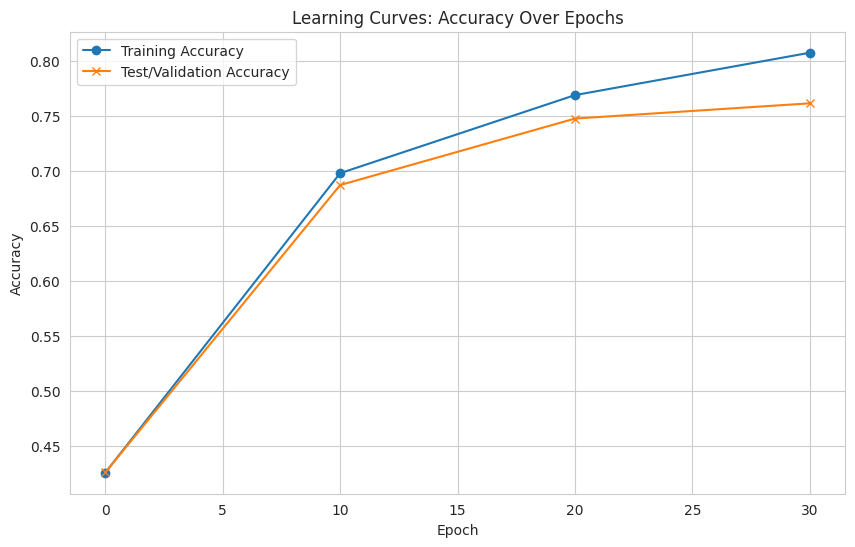


Training Complete. Final Train Acc: 0.8071, Final Test Acc: 0.7611

Naive AlexNet Model - Final Train Acc: 0.8071
Naive AlexNet Model - Final Validation Accuracy (on Seen Test Set): 0.7611


In [101]:
from torch.utils.data import ConcatDataset, DataLoader

# 1. Prepare Naive AlexNet Training Data
# final_source_train_loaders already contain (Train + Val) for UMC, VMU, AMC
naive_alexnet_source_datasets = [
    loader.dataset for loader in final_source_train_loaders
]
naive_alexnet_train_dataset = ConcatDataset(naive_alexnet_source_datasets)
naive_alexnet_train_loader = DataLoader(
    naive_alexnet_train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
)

print(f"Naive AlexNet Training Dataset Size: {len(naive_alexnet_train_dataset)}")
print(f"Naive AlexNet Training Loader Batches: {len(naive_alexnet_train_loader)}")

# 2. Initialize and Train Naive AlexNet Model
naive_alexnet_model = alexnet()

# Dummy forward pass to initialize Lazy layers
dummy_input = torch.randn(1, 3, 50, 50)
_ = naive_alexnet_model(dummy_input)
print("Lazy layers initialized for Naive AlexNet model.")

print("\nStarting Naive AlexNet ERM training (30 epochs)...")
naive_alexnet_train_acc, naive_alexnet_val_acc = train_CNN(
    naive_alexnet_model,
    naive_alexnet_train_loader,
    combined_seen_test_loader, # Using combined_seen_test_loader for validation during training
    num_epochs=30
)

print(f"\nNaive AlexNet Model - Final Train Acc: {naive_alexnet_train_acc:.4f}")
print(f"Naive AlexNet Model - Final Validation Accuracy (on Seen Test Set): {naive_alexnet_val_acc:.4f}")


Evaluating Naive AlexNet on Unseen Target Domain (FU Berlin)...
Naive AlexNet - Final Test Accuracy on FU Berlin: 0.6093
Naive AlexNet - Final Test F1-Score on FU Berlin: 0.5973

Evaluating MLDG AlexNet on Unseen Target Domain (FU Berlin)...
MLDG AlexNet (Conservative HPs) - Final Test Accuracy on FU Berlin: 0.6854
MLDG AlexNet (Conservative HPs) - Final Test F1-Score on FU Berlin: 0.6899

--- AlexNet Generalization Comparison on FU Berlin ---


,Method,FU Berlin Accuracy,FU Berlin F1-Score
0,MLDG AlexNet,0.6854,0.6899
1,Naive AlexNet,0.6093,0.5973


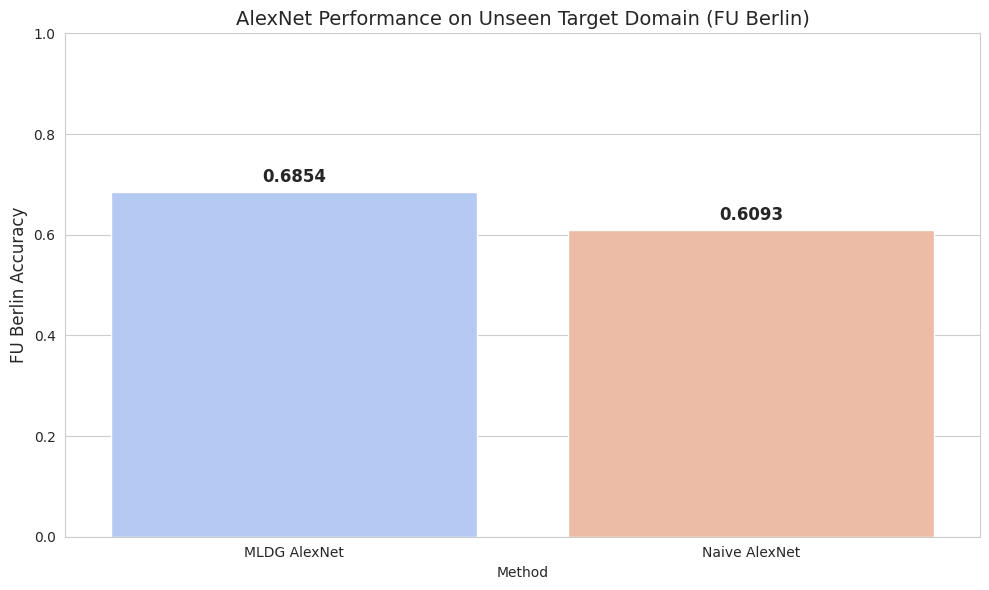

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Helper function to get predictions and labels
def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            # Robust batch unpacking logic
            if isinstance(batch, dict):
                inputs = batch.get('image')
                if inputs is None:
                    inputs = batch.get('images')

                labels = batch.get('label')
                if labels is None:
                    labels = batch.get('labels')

                if inputs is None or labels is None:
                    raise KeyError(f"Dictionary batch did not contain expected keys (e.g., 'image'/'images', 'label'/'labels'). Found keys: {batch.keys()}")
            elif isinstance(batch, (list, tuple)):
                inputs, labels = batch[0], batch[1]
            else:
                raise TypeError(f"Unexpected batch type: {type(batch)}. Expected dict, list, or tuple.")

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Evaluate Naive AlexNet on the Unseen Target Domain (FU Berlin)
print("\nEvaluating Naive AlexNet on Unseen Target Domain (FU Berlin)...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

true_labels_naive, pred_labels_naive = get_predictions_and_labels(naive_alexnet_model, unseen_test_loader, device)
naive_alexnet_fu_berlin_acc = accuracy_score(true_labels_naive, pred_labels_naive)
naive_alexnet_fu_berlin_f1 = f1_score(true_labels_naive, pred_labels_naive, average='weighted')

print(f"Naive AlexNet - Final Test Accuracy on FU Berlin: {naive_alexnet_fu_berlin_acc:.4f}")
print(f"Naive AlexNet - Final Test F1-Score on FU Berlin: {naive_alexnet_fu_berlin_f1:.4f}")

# Evaluate MLDG AlexNet on the Unseen Target Domain (FU Berlin)
print("\nEvaluating MLDG AlexNet on Unseen Target Domain (FU Berlin)...")
true_labels_mldg, pred_labels_mldg = get_predictions_and_labels(final_mldg_alexnet_conservative, unseen_test_loader, device)
fu_berlin_acc_conservative = accuracy_score(true_labels_mldg, pred_labels_mldg)
fu_berlin_f1_conservative = f1_score(true_labels_mldg, pred_labels_mldg, average='weighted')

print(f"MLDG AlexNet (Conservative HPs) - Final Test Accuracy on FU Berlin: {fu_berlin_acc_conservative:.4f}")
print(f"MLDG AlexNet (Conservative HPs) - Final Test F1-Score on FU Berlin: {fu_berlin_f1_conservative:.4f}")

# Compare MLDG AlexNet (conservative) vs Naive AlexNet on FU Berlin
comparison_data_alexnet = {
    'Method': ['MLDG AlexNet', 'Naive AlexNet'],
    'FU Berlin Accuracy': [fu_berlin_acc_conservative, naive_alexnet_fu_berlin_acc],
    'FU Berlin F1-Score': [fu_berlin_f1_conservative, naive_alexnet_fu_berlin_f1]
}
comparison_df_alexnet = pd.DataFrame(comparison_data_alexnet)

print("\n--- AlexNet Generalization Comparison on FU Berlin ---")
display(comparison_df_alexnet.round(4))

# Create Bar Chart (for Accuracy, as F1-Score would require separate plotting logic or a more complex grouped bar)
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df_alexnet, x='Method', y='FU Berlin Accuracy', hue='Method', palette='coolwarm', legend=False)

# Add labels and title
plt.title('AlexNet Performance on Unseen Target Domain (FU Berlin)', fontsize=14)
plt.ylabel('FU Berlin Accuracy', fontsize=12)
plt.ylim(0, 1.0) # Accuracy is between 0 and 1

# Add value labels on top of bars
for i, v in enumerate(comparison_data_alexnet['FU Berlin Accuracy']):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('alexnet_mldg_vs_naive_comparison_fu_berlin.png')
plt.show()